# Предсказание температуры плавления стали

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

Изучим данные представленные заказчиком.

## Изучение данных

### Первичный осмотр

Откроем и изучим данные для составленияя плана работы.

#### Импорты библиотек и модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.metrics import mean_absolute_error # для расчета MAE
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from scipy import stats as st # для доверительного интервала
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# чтение файла с данными и сохранение в df 
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
# откроем все датасеты одной функцией, на вход функция принимает все датасеты сразу 
def info_df(data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time):
    df_all = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time] 
    for i in df_all: 
        display(i.head()) # первые пять строк 
        display(i.info()) # общую информацию 
        display(i.isna().sum()) # пропуски 
        display(i.duplicated().sum()) # дубликаты 

display(info_df(data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time)) 

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

0

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

0

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:46:38    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:31:06    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:48:43    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:18:50    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   
1    NaN     NaN     NaN  2019-05-03 11:40:20     NaN  2019-05-03 11:40:20   
2    NaN     NaN     NaN  2019-05-03 12:09:40     NaN  2019-05-03 12:09:40   
3    NaN     NaN     NaN  2019-05-03 12:41:24     NaN  2019-05-03 12:41:24   
4    NaN     NaN     NaN  2019-05-03 13:12:56     NaN  2019-05-03 13:12:56   

               Bulk 15  
0  2019-05-03 11:03:52  
1  2019-05-03 11:40:20  
2  2019-05-03 12:09:40  
3  2019-05-03 12:41:24  
4  2019-05-03 13:12:56

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

0

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

key      0
Газ 1    0
dtype: int64

0

key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

key                0
Время замера       0
Температура     2901
dtype: int64

0

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

0

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:11:41                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:46:10                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:13:47                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:48:05                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:18:15  2019-05-03 13:32:06    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

0

None

**Вывод**

Открыли семь датасетов с данными. Лишь у двух датасетов нет пропусков. У всех остальных достаточно много пропусков, у всех разный язык в именовании столбцов и не соблюдён snake_case. Почти у всех датасетов много значений NaN! Соответственно и тип данных стал object. Получается имеем чистые датасеты data_arc — данные об электродах и data_gas — данные о продувке сплава газом. Далее проведём исследовательский анализ данных.

### EDA

Так как целью нашего проекта является предсказание температуры плавления стали, соответственно определим таргет для моделей машинного обучения - столбец температура датасета  data_temp.

Однако, столбец с температурой содержит несколько итераций взятия данных о температуре. Об этом как раз писалось выше, в описании проекта. Есть в производстве цикл - домешивают в сталь компоненты, , нагревают и снимат температуру и хим анализ. У одного ключа будет несколько строк с данными о температуре и добавкам. Посмотрим какая есть информация во всех датасетах, исследуем один ключ, пусть будет ключ под номером 1.

#### Исследование столбца "Температура"

In [4]:
data_temp[data_temp['key'].isin([1])]

key         Время замера  Температура
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0

In [5]:
data_arc[data_arc['key'].isin([1])]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.976059   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.805607   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.744363   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           1.659363   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.692755   

   Реактивная мощность  
0             0.687084  
1             0.520285  
2             0.498805  
3             1.062669  
4             0.414397

In [6]:
data_bulk[data_bulk['key'].isin([1])]

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0

In [7]:
data_bulk_time[data_bulk_time['key'].isin([1])]

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:21:30    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:03:52     NaN  2019-05-03 11:03:52   

               Bulk 15  
0  2019-05-03 11:03:52

In [8]:
data_gas[data_gas['key'].isin([1])]

key      Газ 1
0    1  29.749986

In [9]:
data_wire[data_wire['key'].isin([1])]

key     Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN

In [10]:
data_wire_time[data_wire_time['key'].isin([1])]

key               Wire 1 Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8  \
0    1  2019-05-03 11:11:41    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

  Wire 9  
0    NaN

Общая картина складывается следующая: Мы увидели несколько итераций нагрева и снятия температуры после окончания нагрева, увидели как в процессе нагрева подавали материалы. Сыпучие материалы подавали 15 раз, а проволочные - 9. Конечно опять много данных нет. В датасетах по добавкам материалов, есть схожесть, где добавляли материал, там есть и дата.

#### Изучение распределения данных мощности

In [11]:
#Построим графики чтобы посмотреть на распределение
def dist_and_box(df,col):
    global title
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    sns.set(font_scale=1.10)
    distplot = sns.distplot(df[col],ax=axs[0]).set_title(f'Признак {title}',fontsize=20);
    sns.boxplot(df[col], ax=axs[1]).set_title(f'Признак {title}',fontsize=20)

In [12]:
df = data_arc
title = 'Активная мощность'

dist_and_box(data_arc,'Активная мощность')

In [13]:
data_arc.describe()

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388

Распределение данных скошено вправо, о чём и говорит ящик с усами. Виден отдельно стоящий выброс больше значения в 3,5.

In [14]:
df = data_arc
title = 'Реактивная мощность'

dist_and_box(data_arc,'Реактивная мощность')

В реактивной мощности сразу виден один выброс в отрицательное значение. Его стоит изучить детально.

In [15]:
data_arc[data_arc['Реактивная мощность'] < -700]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-24 00:44:48  2019-07-24 00:46:37           0.495782   

      Реактивная мощность  
9780          -715.504924

Посмотрим какие сведения ещё есть по ключу 2116.

In [16]:
data_arc[data_arc['key'].isin([2116])]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9778  2116  2019-07-24 00:29:52  2019-07-24 00:31:54           0.433266   
9779  2116  2019-07-24 00:35:50  2019-07-24 00:38:05           0.620265   
9780  2116  2019-07-24 00:44:48  2019-07-24 00:46:37           0.495782   
9781  2116  2019-07-24 00:51:51  2019-07-24 00:52:58           0.299368   

      Реактивная мощность  
9778             0.306141  
9779             0.408352  
9780          -715.504924  
9781             0.198796

In [17]:
data_temp[data_temp['key'].isin([2116])]

key         Время замера  Температура
10462  2116  2019-07-24 00:32:59       1579.0
10463  2116  2019-07-24 00:44:34       1574.0
10464  2116  2019-07-24 00:50:58       1578.0
10465  2116  2019-07-24 00:53:31       1578.0

Вывод по аномальному значению: Реактивная мощность у нескольких итераций варьируется в одном периоде, а одно значение явно вылетает за период. Температура также подавалась, как и при других итерациях. Значит данное  значение удалим при предобработке данных.

#### Изучение распределения данных температуры

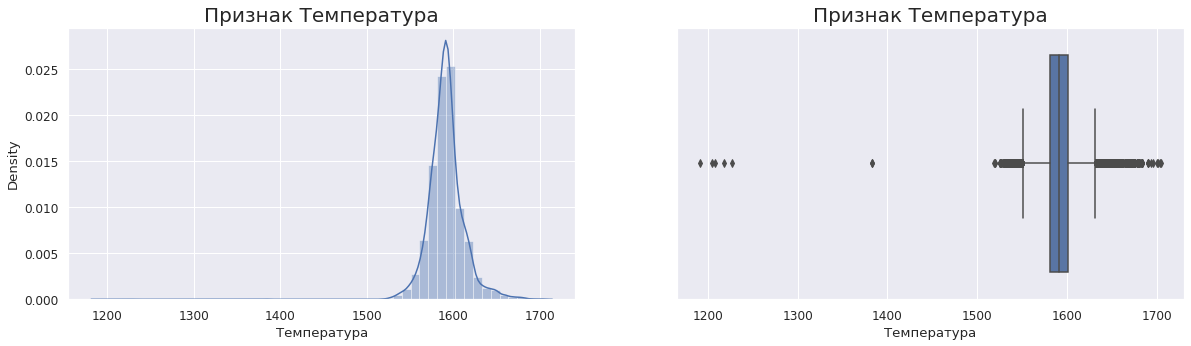

In [18]:
df = data_temp
title = 'Температура'

dist_and_box(data_temp,'Температура')

In [19]:
data_temp.describe()

key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

Распределение у температуры вполне нормальное, однако есть выбросы. Меньше значения 1300 порядка пяти выбросов.

In [20]:
data_temp[data_temp['Температура'] < 1400]

key         Время замера  Температура
4350    867  2019-06-04 14:21:00       1191.0
5978   1214  2019-06-16 05:32:00       1208.0
7958   1619  2019-06-30 11:03:54       1218.0
8913   1818  2019-07-07 00:30:49       1383.0
8914   1818  2019-07-07 00:31:40       1383.0
10127  2052  2019-07-21 14:51:40       1227.0
12564  2561  2019-08-08 07:34:15       1204.0

Замеры температурыу нескольких ключей брались один раз. Это явная недоработка в данных. Такие жанные не попадут в финальный датасет, поскольку температуру мы будем брать по первому и последнему значению.

#### Изучение распределения данных газа

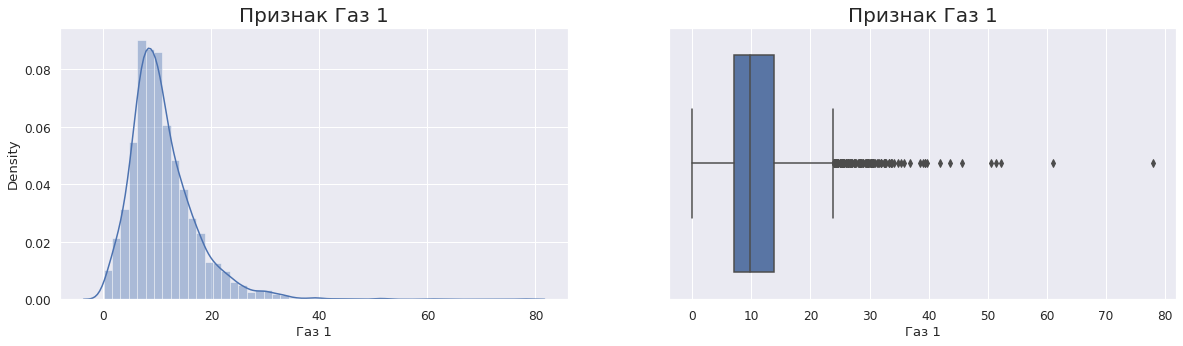

In [21]:
df = data_gas
title = 'Газ 1'

dist_and_box(data_gas,'Газ 1')

In [22]:
data_gas.describe()

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Распределение слегка скошено вправо, о чём и говорят выбросы на ящике с усами. Но здесь значения единичные у газа по каждому ключу. Так как заказчик утверждает, что такие значения могут присутствовать в производстве, то оставим их.

#### Изучение распределения данных о проволочных материалах

In [23]:
df = data_wire
title = 'Wire 1'

dist_and_box(data_wire,'Wire 1')

In [24]:
df = data_wire
title = 'Wire 2'

dist_and_box(data_wire,'Wire 2')

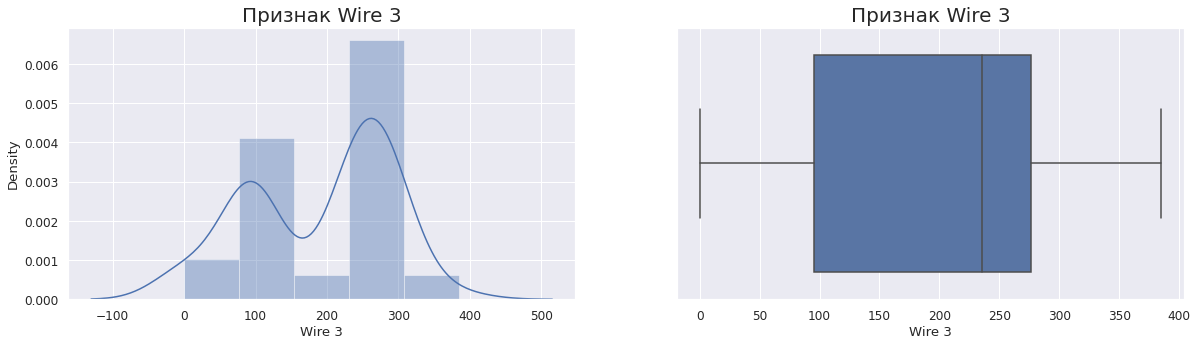

In [25]:
df = data_wire
title = 'Wire 3'

dist_and_box(data_wire,'Wire 3')

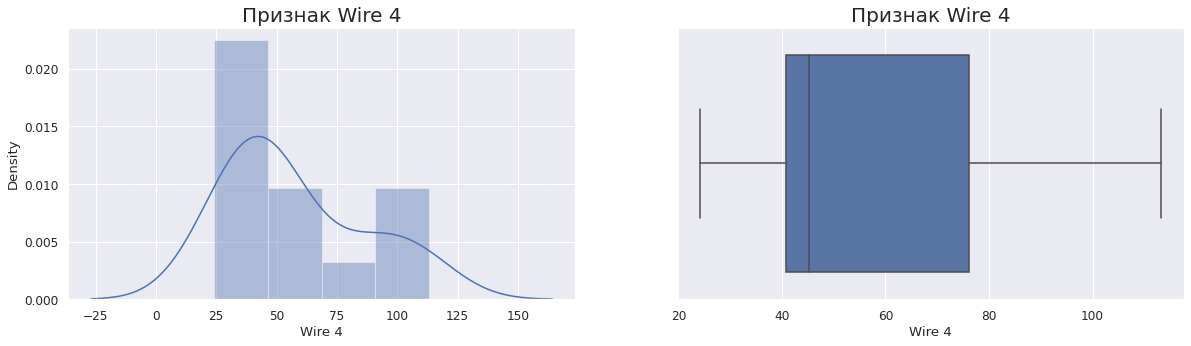

In [26]:
df = data_wire
title = 'Wire 4'

dist_and_box(data_wire,'Wire 4')

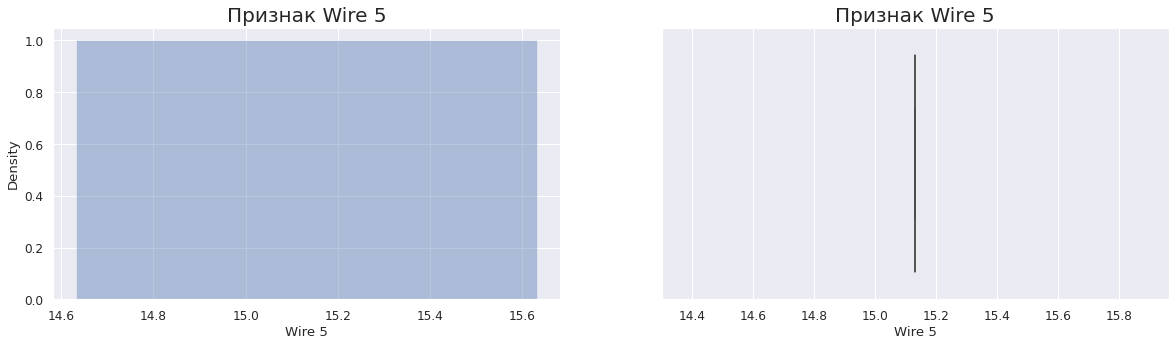

In [27]:
df = data_wire
title = 'Wire 5'

dist_and_box(data_wire,'Wire 5')

In [28]:
data_wire['Wire 5'].unique()

array([   nan, 15.132])

In [29]:
data_wire[data_wire['Wire 5'].isin([15.132])]

key    Wire 1  Wire 2     Wire 3  Wire 4  Wire 5     Wire 6  Wire 7  \
2440  2567  18.30192     NaN  96.288193     NaN  15.132  73.307526     NaN   

      Wire 8  Wire 9  
2440     NaN     NaN

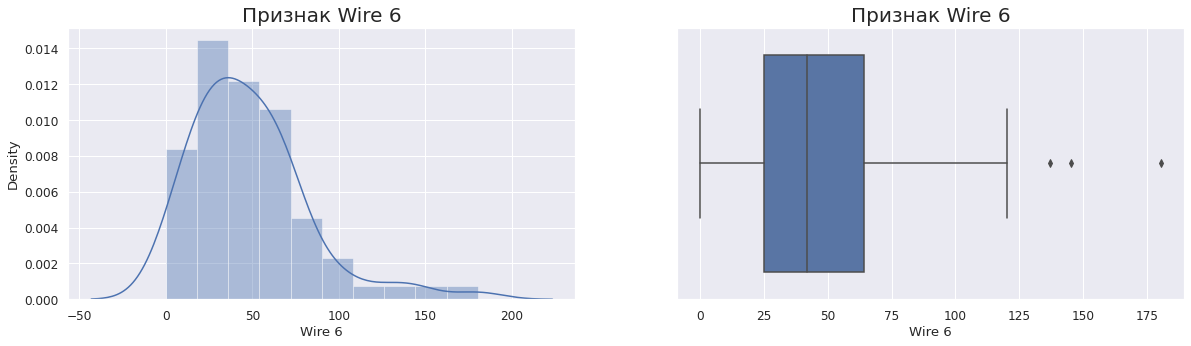

In [30]:
df = data_wire
title = 'Wire 6'

dist_and_box(data_wire,'Wire 6')

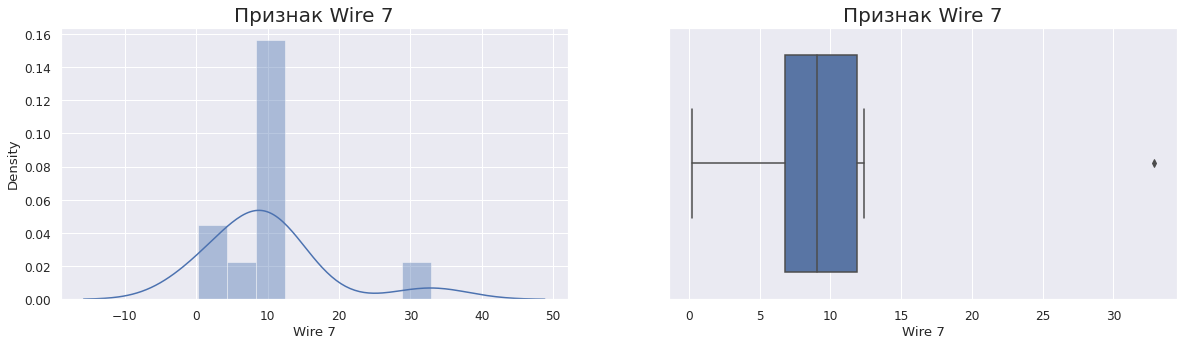

In [31]:
df = data_wire
title = 'Wire 7'

dist_and_box(data_wire,'Wire 7')

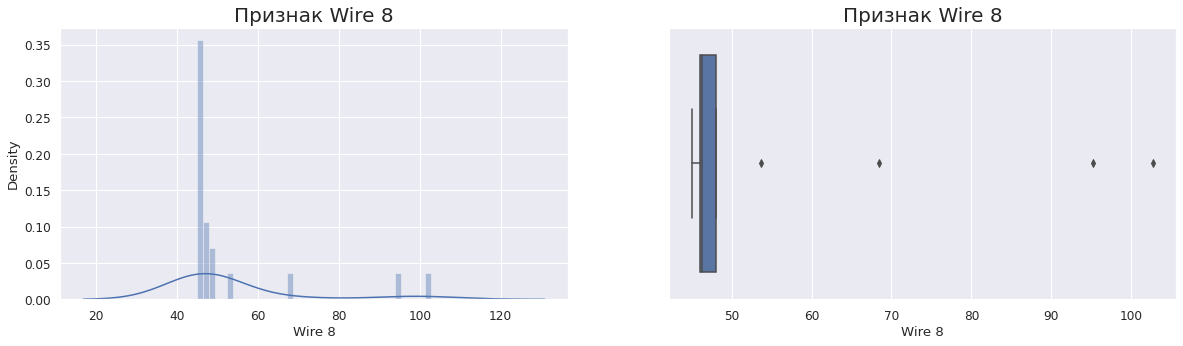

In [32]:
df = data_wire
title = 'Wire 8'

dist_and_box(data_wire,'Wire 8')

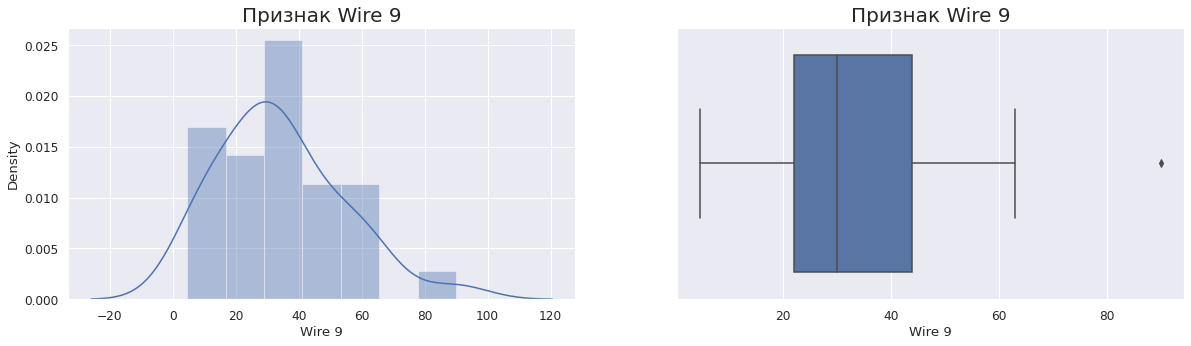

In [33]:
df = data_wire
title = 'Wire 9'

dist_and_box(data_wire,'Wire 9')

In [34]:
data_wire.describe()

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

Только у первого столбца почти нормальное распределение. У остальных наблюдаются пики по нескольким значениям, а в столбце 5 вообще только одно значение и присутствует. 

<font color='steelblue'><b>Комментарий тимлида</b></font><br>
<font color='green'>✔️ Согласна.</font><br>

#### Изучение распределения данных о сыпучих материалах

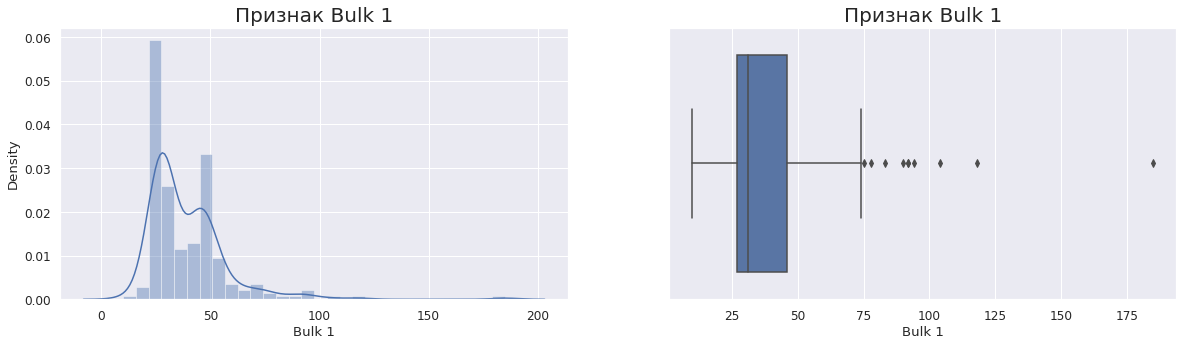

In [35]:
df = data_bulk
title = 'Bulk 1'

dist_and_box(data_bulk,'Bulk 1')

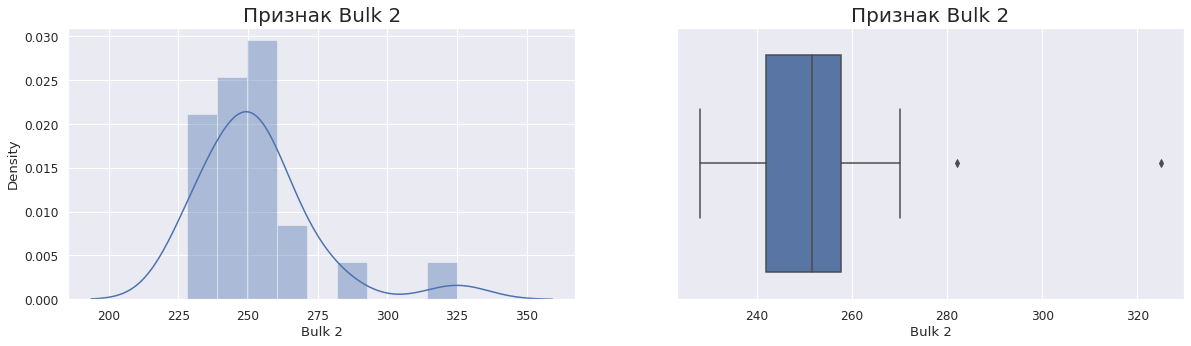

In [36]:
df = data_bulk
title = 'Bulk 2'

dist_and_box(data_bulk,'Bulk 2')

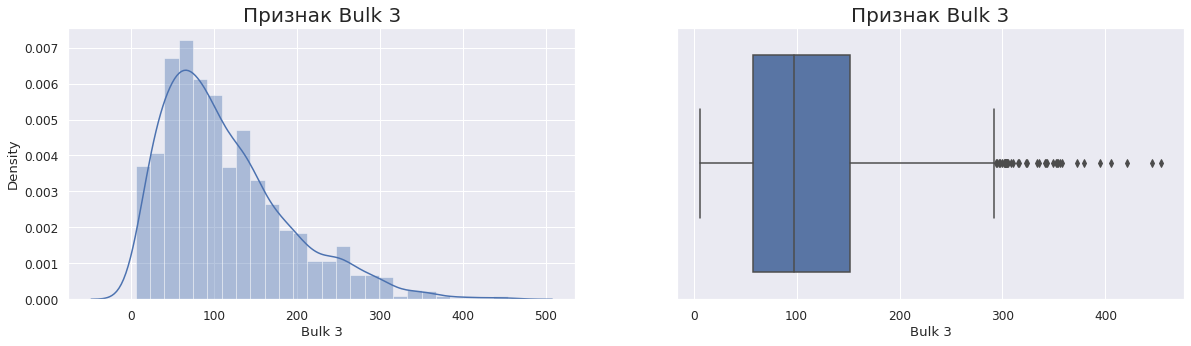

In [37]:
df = data_bulk
title = 'Bulk 3'

dist_and_box(data_bulk,'Bulk 3')

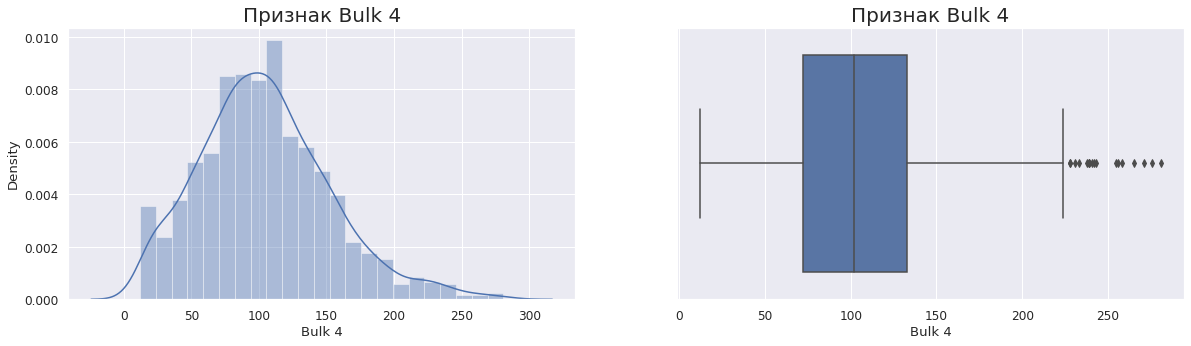

In [38]:
df = data_bulk
title = 'Bulk 4'

dist_and_box(data_bulk,'Bulk 4')

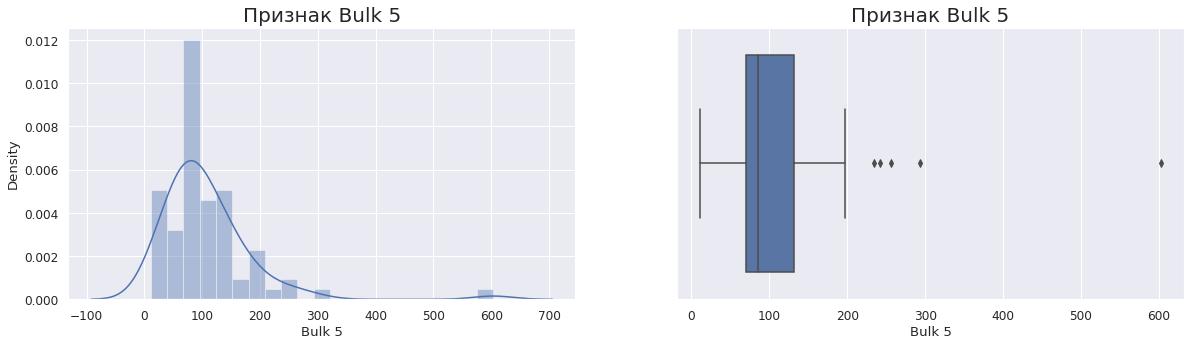

In [39]:
df = data_bulk
title = 'Bulk 5'

dist_and_box(data_bulk,'Bulk 5')

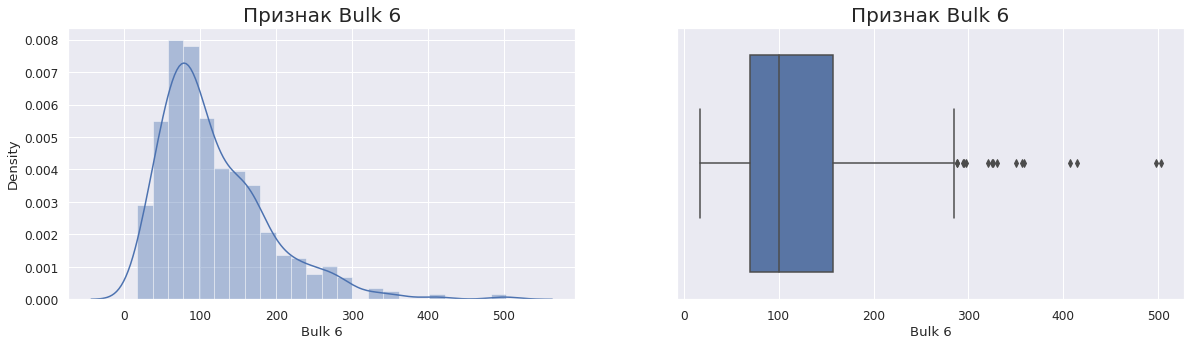

In [40]:
df = data_bulk
title = 'Bulk 6'

dist_and_box(data_bulk,'Bulk 6')

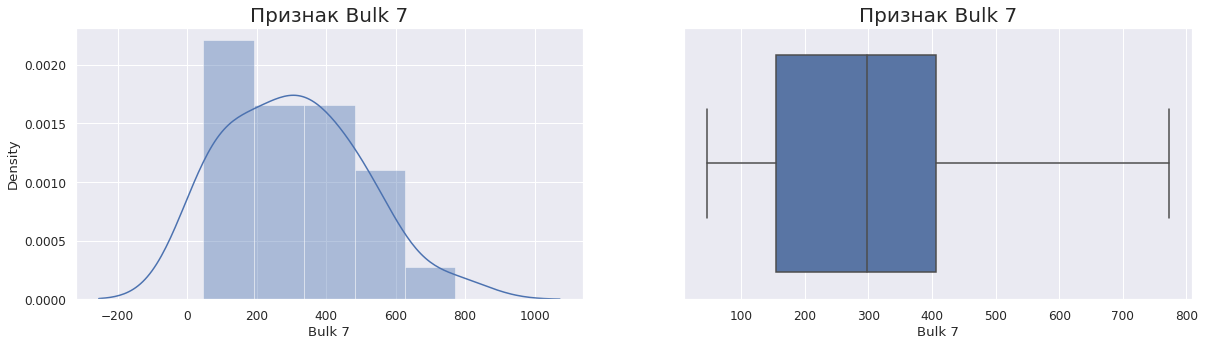

In [41]:
df = data_bulk
title = 'Bulk 7'

dist_and_box(data_bulk,'Bulk 7')

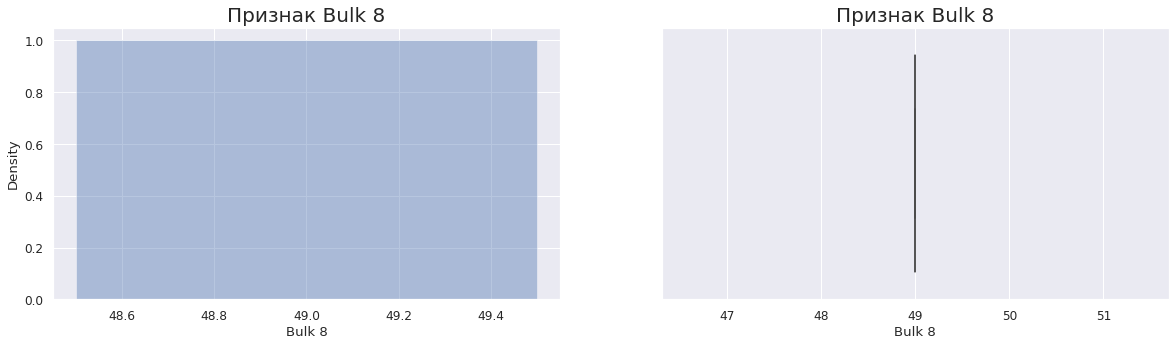

In [42]:
df = data_bulk
title = 'Bulk 8'

dist_and_box(data_bulk,'Bulk 8')

In [43]:
data_bulk['Bulk 8'].unique()

array([nan, 49.])

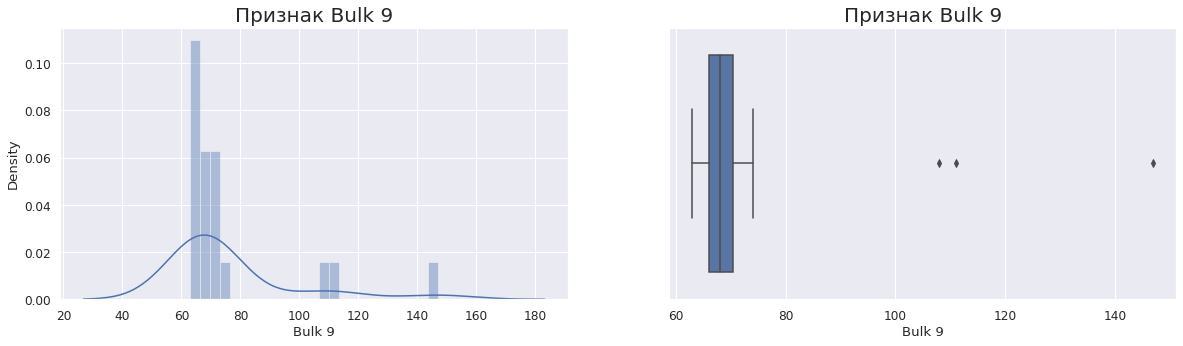

In [44]:
df = data_bulk
title = 'Bulk 9'

dist_and_box(data_bulk,'Bulk 9')

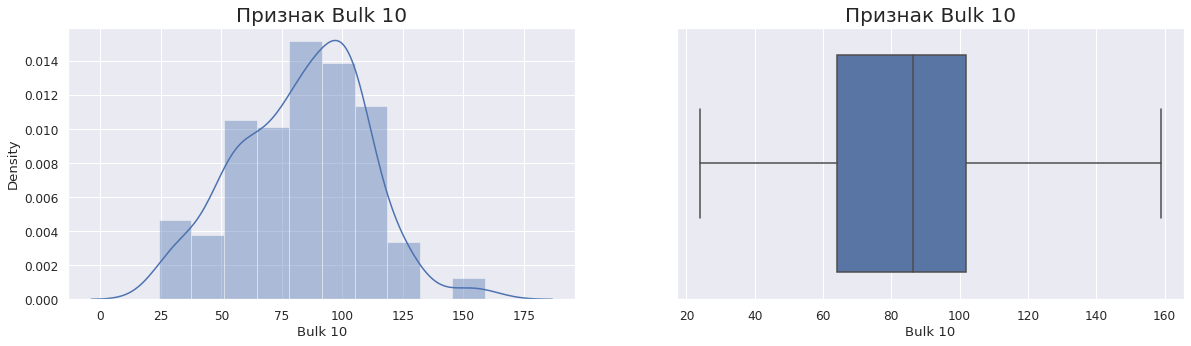

In [45]:
df = data_bulk
title = 'Bulk 10'

dist_and_box(data_bulk,'Bulk 10')

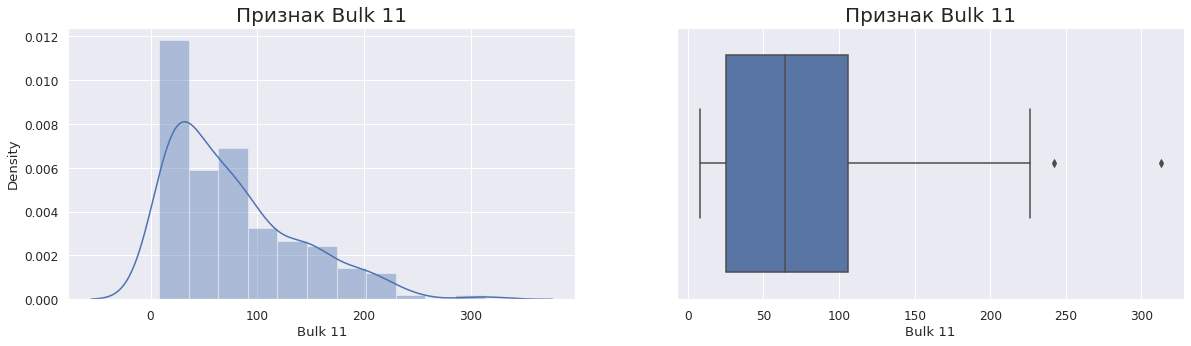

In [46]:
df = data_bulk
title = 'Bulk 11'

dist_and_box(data_bulk,'Bulk 11')

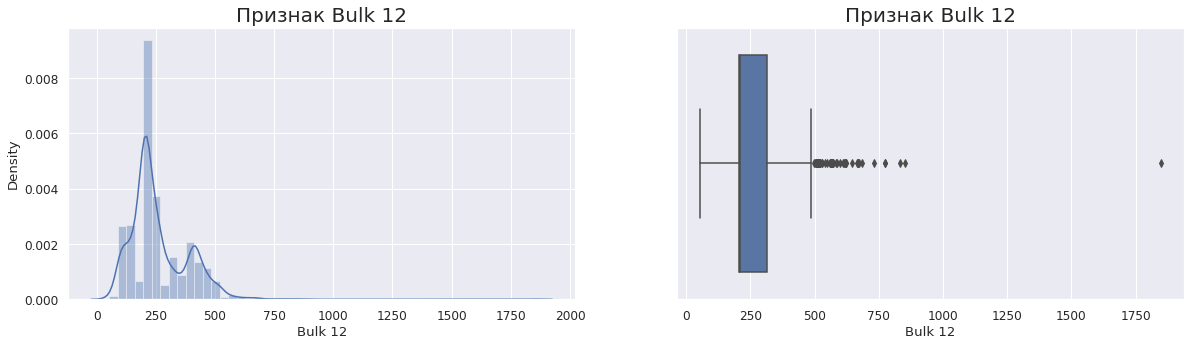

In [47]:
df = data_bulk
title = 'Bulk 12'

dist_and_box(data_bulk,'Bulk 12')

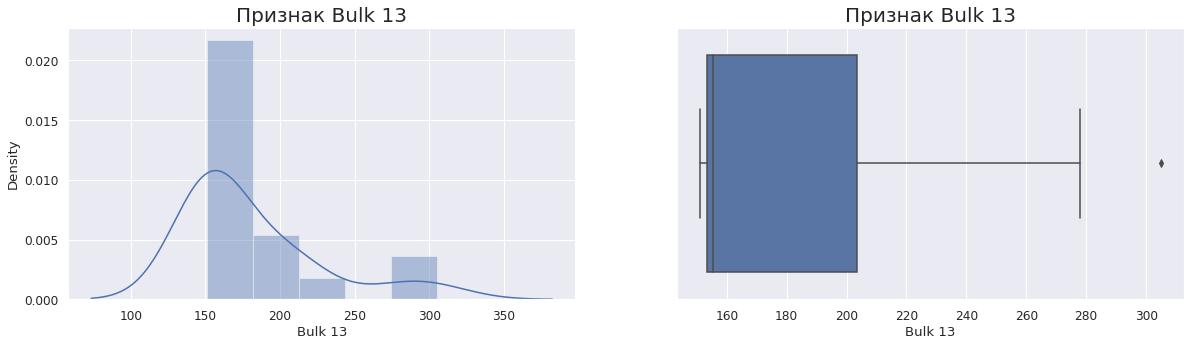

In [48]:
df = data_bulk
title = 'Bulk 13'

dist_and_box(data_bulk,'Bulk 13')

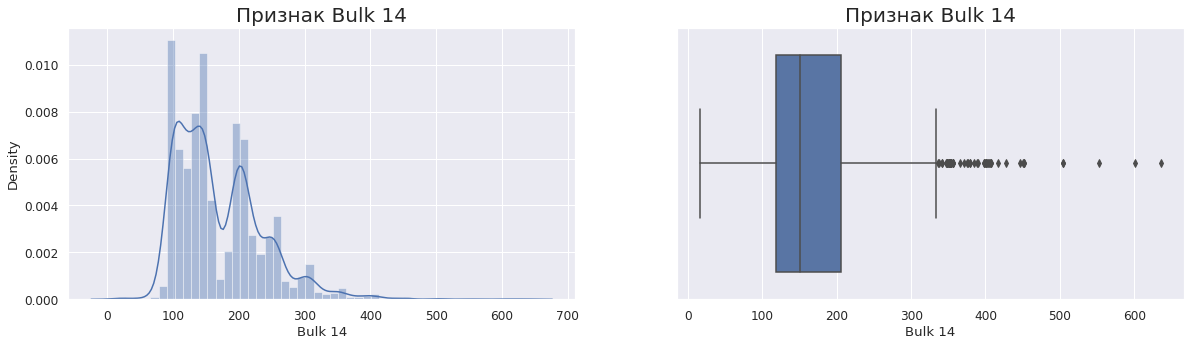

In [49]:
df = data_bulk
title = 'Bulk 14'

dist_and_box(data_bulk,'Bulk 14')

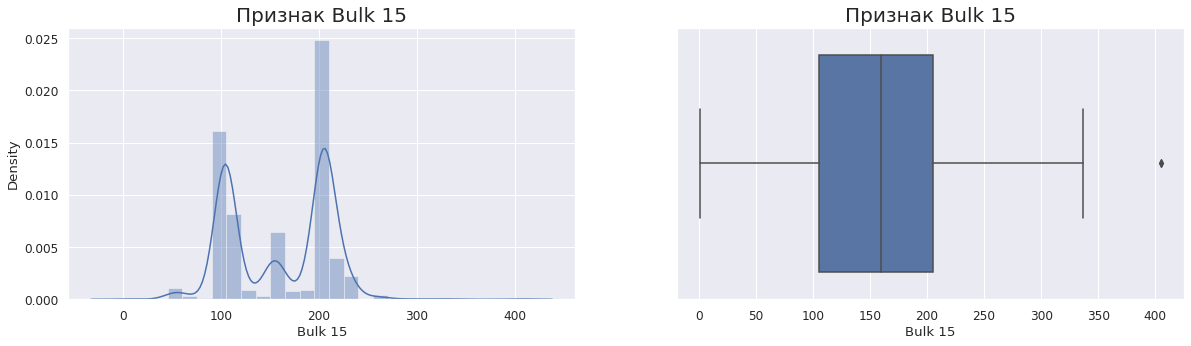

In [50]:
df = data_bulk
title = 'Bulk 15'

dist_and_box(data_bulk,'Bulk 15')

In [51]:
data_bulk.describe()

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

Столбец 4 представлен более менее нормальным распределением, остальные имеют пики в несколько значений. Столбец 8 представлен одним значением.

**Вывод**

Провели первичный осмотр и детальный EDA и делаем выводы по 1 пункту:

Множественные пропуски значений в столбцах, а также NaN. Это конечно могут быть некорректно снятые данные с датчиков.

В разных датасетах разное количество уникальных номеров key. Возможно какие-то данные были утеряны или эта партия не проходила тех.этап.

Не соответствующий значениям тип данных.

Разноязычные названия столбцов. Именование столбцов нужно привести к snake_case/

Время нужно перевести в формат datetime.

Аномальное значение реактивной мощности в таблице data_arc. Явно ошибочное значение - удалим его.

Есть выбросы в разных датасетах, но их трогать не будем, так как данные должны быть приближены к реальности.

Таблицы с временем по добавке материалов брать в объединение не будем. Они как признак не нужны. 

Данные требуют предобработки. 

## Предобработка данных

### Нужно привести наименования столбцов к snake_case

In [52]:
data_arc.columns = ['key', 'start_time','end_time', 'active_power', 'reactive_power']
data_temp.columns = ['key', 'measurement_time', 'temperature']
data_gas.columns = ['key', 'gas_1']
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [53]:
def info_df(data_arc, data_bulk, data_gas, data_temp, data_wire):
    df_all = [data_arc, data_bulk, data_gas, data_temp, data_wire] 
    for i in df_all: 
        display(i.head()) # первые пять строк 
        
display(info_df(data_arc, data_bulk, data_gas, data_temp, data_wire)) 

key           start_time             end_time  active_power  reactive_power
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02      0.976059        0.687084
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33      0.805607        0.520285
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36      0.744363        0.498805
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19      1.659363        1.062669
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37      0.692755        0.414397

key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0

key      gas_1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

key     measurement_time  temperature
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0
2    1  2019-05-03 11:29:11       1618.0
3    1  2019-05-03 11:30:01       1601.0
4    1  2019-05-03 11:30:39       1613.0

key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

None

### Удалить аномальное значение в реактивной мощности

In [54]:
data_arc = data_arc.query('reactive_power > 0')
data_arc.describe()

key  active_power  reactive_power
count  14875.000000  14875.000000    14875.000000
mean    1615.186756      0.670453        0.500723
std      934.593897      0.408170        0.310880
min        1.000000      0.030002        0.020806
25%      806.000000      0.395295        0.291003
50%     1617.000000      0.555565        0.415984
75%     2429.000000      0.857049        0.637403
max     3241.000000      3.731596        2.676388

In [55]:
data_arc[data_arc['key'].isin([2116])]

key           start_time             end_time  active_power  \
9778  2116  2019-07-24 00:29:52  2019-07-24 00:31:54      0.433266   
9779  2116  2019-07-24 00:35:50  2019-07-24 00:38:05      0.620265   
9781  2116  2019-07-24 00:51:51  2019-07-24 00:52:58      0.299368   

      reactive_power  
9778        0.306141  
9779        0.408352  
9781        0.198796

### Значения в мощности проссумировать

In [56]:
data_arc_sum = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.sum,
                                      'reactive_power': np.sum})
data_arc_sum.columns = ['active_power_sum','reactive_power_sum']
data_arc_sum.head()
data_arc_sum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   active_power_sum    3214 non-null   float64
 1   reactive_power_sum  3214 non-null   float64
dtypes: float64(2)
memory usage: 75.3 KB


Для дальнейшей работы необходимо подготовить значения key, удалить из таблицы key, которые не подходят по следующим условиям:

нет окончательного замера, 

только один замер температуры.

Сравнивать будем две таблицы data_temp и data_arc по столбцам время замера и окочательное время соотвественно. 

In [57]:
# выделим такие значения
bad_keys = []
for key in list(data_temp['key'].unique()):
    try:
        if ((data_temp[data_temp['key'] == key]['measurement_time'].max() < 
            data_arc[data_arc['key'] == key]['end_time'].max()) or
           (data_temp[data_temp['key'] == key]['measurement_time'].max() == 
            data_temp[data_temp['key'] == key]['measurement_time'].min())):
            bad_keys.append(key)
    except:
        bad_keys.append(key) # получаем плохие ключи
display(bad_keys, len(bad_keys))

[11,
 38,
 43,
 51,
 64,
 69,
 73,
 81,
 177,
 179,
 180,
 182,
 185,
 195,
 213,
 216,
 220,
 222,
 267,
 271,
 279,
 293,
 296,
 297,
 321,
 325,
 326,
 444,
 445,
 448,
 453,
 456,
 470,
 471,
 472,
 491,
 535,
 562,
 586,
 587,
 588,
 590,
 592,
 593,
 596,
 616,
 638,
 641,
 704,
 731,
 733,
 741,
 757,
 786,
 869,
 870,
 874,
 878,
 928,
 929,
 932,
 934,
 997,
 1057,
 1060,
 1152,
 1153,
 1161,
 1232,
 1313,
 1316,
 1341,
 1371,
 1381,
 1402,
 1433,
 1458,
 1461,
 1464,
 1493,
 1505,
 1558,
 1578,
 1618,
 1622,
 1623,
 1624,
 1639,
 1657,
 1683,
 1685,
 1712,
 1713,
 1720,
 1724,
 1811,
 1813,
 1837,
 1872,
 1873,
 1876,
 1946,
 1949,
 1964,
 1966,
 1987,
 1989,
 1990,
 1992,
 1993,
 1994,
 2053,
 2078,
 2138,
 2140,
 2142,
 2143,
 2152,
 2211,
 2221,
 2261,
 2263,
 2265,
 2300,
 2303,
 2389,
 2390,
 2393,
 2398,
 2425,
 2427,
 2451,
 2457,
 2522,
 2540,
 2543,
 2544,
 2572,
 2601,
 2604,
 2606,
 2667,
 2670,
 2671,
 2695,
 2698,
 2736,
 2743,
 2787,
 2808,
 2809,
 2814,
 2838,


171

In [58]:
# отсортируем датасет, исключив плохие ключи
data_temp = data_temp.query('key not in @bad_keys')
data_temp.info() 
data_temp.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15176 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               15176 non-null  int64  
 1   measurement_time  15176 non-null  object 
 2   temperature       12381 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 474.2+ KB


key     measurement_time  temperature
0     1  2019-05-03 11:16:18       1571.0
1     1  2019-05-03 11:25:53       1604.0
2     1  2019-05-03 11:29:11       1618.0
3     1  2019-05-03 11:30:01       1601.0
4     1  2019-05-03 11:30:39       1613.0
5     2  2019-05-03 11:37:27       1581.0
6     2  2019-05-03 11:38:00       1577.0
7     2  2019-05-03 11:49:38       1589.0
8     2  2019-05-03 11:55:50       1604.0
9     2  2019-05-03 11:58:24       1608.0
10    2  2019-05-03 11:59:12       1602.0
11    3  2019-05-03 12:13:17       1596.0
12    3  2019-05-03 12:18:36       1597.0
13    3  2019-05-03 12:25:06       1598.0
14    3  2019-05-03 12:30:48       1599.0
15    3  2019-05-03 12:34:57       1599.0
16    4  2019-05-03 12:52:57       1601.0
17    4  2019-05-03 12:58:43       1623.0
18    4  2019-05-03 12:59:25       1625.0
19    5  2019-05-03 13:23:19       1576.0
20    5  2019-05-03 13:36:01       1602.0
21    6  2019-05-03 13:49:24       1543.0
22    6  2019-05-03 14:04:31       1581.0
23    6  2019-05-03 14:11:11       1600.0
24    6  2019-05-03 14:11:50       1600.0
25    6  2019-05-03 14:12:29       1596.0
26    7  2019-05-03 14:19:43       1586.0
27    7  2019-05-03 14:20:19       1582.0
28    7  2019-05-03 14:32:07       1599.0
29    7  2019-05-03 14:38:48       1595.0
30    7  2019-05-03 14:42:37       1599.0
31    8  2019-05-03 15:07:18       1577.0
32    8  2019-05-03 15:17:09       1604.0
33    8  2019-05-03 15:20:42       1600.0
34    8  2019-05-03 15:22:52       1598.0
35    9  2019-05-03 15:37:03       1587.0
36    9  2019-05-03 15:45:37       1589.0
37    9  2019-05-03 15:51:15       1597.0
38    9  2019-05-03 15:58:39       1589.0
39    9  2019-05-03 16:01:16       1592.0
40   10  2019-05-03 16:14:29       1574.0
41   10  2019-05-03 16:21:26       1580.0
42   10  2019-05-03 16:28:18       1585.0
43   10  2019-05-03 16:29:05       1586.0
44   10  2019-05-03 16:32:37       1586.0
45   10  2019-05-03 16:33:05       1586.0
46   10  2019-05-03 16:35:26       1588.0
47   10  2019-05-03 16:36:08       1593.0
52   12  2019-05-03 17:40:54       1606.0
53   12  2019-05-03 17:52:25       1606.0

Проверили, что отсортированный например плохой ключ - 11, не попал в таблицу отсортировнаную. 

Также проверим, нет ли некооректных ключей, то есть в количестве меньше 2 в таблице.

In [59]:
(data_temp['key'].value_counts() < 2).sum()

0

Убедились, что нет.

### Отсортировать датасет с температурой, оставив только начальные и конечные значения температуры 

Далее, формируем датасет с температурой - нужно оставить начальное и конечное значение темпы.

In [60]:
data_temp.head(2)

key     measurement_time  temperature
0    1  2019-05-03 11:16:18       1571.0
1    1  2019-05-03 11:25:53       1604.0

In [61]:
data_temp.columns = ['key', 'measurement_time','temperature']
data_temp_new = pd.pivot_table(data_temp,
                                values='measurement_time',
                                index='key',
                                aggfunc={'measurement_time': [np.min, np.max]})

data_temp_new.head(5)

amax                 amin
key                                          
1    2019-05-03 11:30:39  2019-05-03 11:16:18
2    2019-05-03 11:59:12  2019-05-03 11:37:27
3    2019-05-03 12:34:57  2019-05-03 12:13:17
4    2019-05-03 12:59:25  2019-05-03 12:52:57
5    2019-05-03 13:36:01  2019-05-03 13:23:19

Получили таблицу со столбцами максимального и минимального времени. 

Далее нужно сформировать новый датасет на основе этих данных.

In [62]:
# получаем списки с начальным и конечным временем
start_time_list = list(data_temp_new['amin'])
end_time_list = list(data_temp_new['amax'])

In [63]:
# записываем в датасет старт время начальное из полученного списка
data_temp_start = data_temp.query('measurement_time in @start_time_list ')
data_temp_start = data_temp_start.set_index('key') # ключ в индексы
data_temp_start.info()
data_temp_start.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3045 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   measurement_time  3045 non-null   object 
 1   temperature       3045 non-null   float64
dtypes: float64(1), object(1)
memory usage: 71.4+ KB


measurement_time  temperature
key                                  
1    2019-05-03 11:16:18       1571.0
2    2019-05-03 11:37:27       1581.0
3    2019-05-03 12:13:17       1596.0
4    2019-05-03 12:52:57       1601.0
5    2019-05-03 13:23:19       1576.0

In [64]:
# записываем в датасет энд время конечное из полученного списка
data_temp_end = data_temp.query('measurement_time in @end_time_list ')
data_temp_end = data_temp_end.set_index('key') # ключ в индексы
data_temp_end.info()
data_temp_end.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3045 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   measurement_time  3045 non-null   object 
 1   temperature       2344 non-null   float64
dtypes: float64(1), object(1)
memory usage: 71.4+ KB


measurement_time  temperature
key                                  
1    2019-05-03 11:30:39       1613.0
2    2019-05-03 11:59:12       1602.0
3    2019-05-03 12:34:57       1599.0
4    2019-05-03 12:59:25       1625.0
5    2019-05-03 13:36:01       1602.0

Теперь приступим к объединению таблиц, сделанных выше, нужно получить только два столбца - начальное и конечное время.

In [65]:
data_temp_final = data_temp_start.copy()
data_temp_final.columns = ['time','start_temp']
data_temp_final['end_temp'] = data_temp_end['temperature']
data_temp_final = data_temp_final.drop('time', axis=1)
data_temp_final.info()
data_temp_final.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3045 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_temp  3045 non-null   float64
 1   end_temp    2344 non-null   float64
dtypes: float64(2)
memory usage: 71.4 KB


start_temp  end_temp
key                      
1        1571.0    1613.0
2        1581.0    1602.0
3        1596.0    1599.0
4        1601.0    1625.0
5        1576.0    1602.0

### Удалить пропуски и NaN

Посмотрим ещё раз в каких таблицах есть пропуски.

In [66]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [67]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14875 non-null  int64  
 1   start_time      14875 non-null  object 
 2   end_time        14875 non-null  object 
 3   active_power    14875 non-null  float64
 4   reactive_power  14875 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 697.3+ KB


In [68]:
data_temp_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3045 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_temp  3045 non-null   float64
 1   end_temp    2344 non-null   float64
dtypes: float64(2)
memory usage: 71.4 KB


In [69]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [70]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


заменим значения на ноль только в датасетах сухих смесей и проволоки. В датасетах про газ и мощность - всё в порядке. А датасет с темпой - имеет пропуски, но их отсечём позже. 

In [71]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

data_bulk.info()
data_bulk.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


key  bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  \
0    1     0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0   
1    2     0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0   
2    3     0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0   
3    4     0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0   
4    5     0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0   
5    6     0.0     0.0     0.0   117.0     0.0     0.0     0.0     0.0   
6    7     0.0     0.0     0.0   117.0     0.0     0.0     0.0     0.0   
7    8     0.0     0.0     0.0    99.0     0.0     0.0     0.0     0.0   
8    9     0.0     0.0     0.0   117.0     0.0     0.0     0.0     0.0   
9   10     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   bulk_9  bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
0     0.0      0.0      0.0    206.0      0.0    150.0    154.0  
1     0.0      0.0      0.0    206.0      0.0    149.0    154.0  
2     0.0      0.0      0.0    205.0      0.0    152.0    153.0  
3     0.0      0.0      0.0    207.0      0.0    153.0    154.0  
4     0.0      0.0      0.0    203.0      0.0    151.0    152.0  
5     0.0      0.0      0.0    204.0      0.0    201.0    154.0  
6     0.0      0.0      0.0    204.0      0.0    152.0    154.0  
7     0.0      0.0      0.0    410.0      0.0    252.0    153.0  
8     0.0      0.0      0.0    107.0      0.0     99.0    203.0  
9     0.0      0.0      0.0    203.0      0.0    102.0    204.0

In [72]:
data_wire.info()
data_wire.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


key      wire_1     wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1   60.059998   0.000000     0.0     0.0     0.0     0.0     0.0     0.0   
1    2   96.052315   0.000000     0.0     0.0     0.0     0.0     0.0     0.0   
2    3   91.160157   0.000000     0.0     0.0     0.0     0.0     0.0     0.0   
3    4   89.063515   0.000000     0.0     0.0     0.0     0.0     0.0     0.0   
4    5   89.238236   9.114560     0.0     0.0     0.0     0.0     0.0     0.0   
5    6   99.109917   9.114560     0.0     0.0     0.0     0.0     0.0     0.0   
6    7   98.061600   0.000000     0.0     0.0     0.0     0.0     0.0     0.0   
7    8  155.282394   0.000000     0.0     0.0     0.0     0.0     0.0     0.0   
8    9  113.393279   9.143681     0.0     0.0     0.0     0.0     0.0     0.0   
9   10   81.244796  12.376000     0.0     0.0     0.0     0.0     0.0     0.0   

   wire_9  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
5     0.0  
6     0.0  
7     0.0  
8     0.0  
9     0.0

Убрали пропуски в нужных таблицах. 

### Объеденим нужные таблицы в общую

Далее объеденим нужные нам таблицы в общую. Нам потребуются датафреймы data_arc_sum, data_temp_final, data_bulk, data_gas и data_wire. В каждой таблице значение  столбца key должно быть преобразовано в index. У data_temp_final и data_arc_sum это сделано. Сделаем у оставшихся.

In [73]:
data_bulk = data_bulk.set_index('key')
data_bulk.columns = [f'bulk_{x}' for x in range(1,16)]
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bulk_1   3129 non-null   float64
 1   bulk_2   3129 non-null   float64
 2   bulk_3   3129 non-null   float64
 3   bulk_4   3129 non-null   float64
 4   bulk_5   3129 non-null   float64
 5   bulk_6   3129 non-null   float64
 6   bulk_7   3129 non-null   float64
 7   bulk_8   3129 non-null   float64
 8   bulk_9   3129 non-null   float64
 9   bulk_10  3129 non-null   float64
 10  bulk_11  3129 non-null   float64
 11  bulk_12  3129 non-null   float64
 12  bulk_13  3129 non-null   float64
 13  bulk_14  3129 non-null   float64
 14  bulk_15  3129 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


bulk_1  bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  bulk_9  \
key                                                                           
1       0.0     0.0     0.0    43.0     0.0     0.0     0.0     0.0     0.0   
2       0.0     0.0     0.0    73.0     0.0     0.0     0.0     0.0     0.0   
3       0.0     0.0     0.0    34.0     0.0     0.0     0.0     0.0     0.0   
4       0.0     0.0     0.0    81.0     0.0     0.0     0.0     0.0     0.0   
5       0.0     0.0     0.0    78.0     0.0     0.0     0.0     0.0     0.0   

     bulk_10  bulk_11  bulk_12  bulk_13  bulk_14  bulk_15  
key                                                        
1        0.0      0.0    206.0      0.0    150.0    154.0  
2        0.0      0.0    206.0      0.0    149.0    154.0  
3        0.0      0.0    205.0      0.0    152.0    153.0  
4        0.0      0.0    207.0      0.0    153.0    154.0  
5        0.0      0.0    203.0      0.0    151.0    152.0

In [74]:
data_gas = data_gas.set_index('key')
data_gas.columns = ['gas']
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gas     3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


gas
key           
1    29.749986
2    12.555561
3    28.554793
4    18.841219
5     5.413692

In [75]:
data_wire = data_wire.set_index('key')
data_wire.columns = [f'wire_{x}' for x in range(1,10)]
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wire_1  3081 non-null   float64
 1   wire_2  3081 non-null   float64
 2   wire_3  3081 non-null   float64
 3   wire_4  3081 non-null   float64
 4   wire_5  3081 non-null   float64
 5   wire_6  3081 non-null   float64
 6   wire_7  3081 non-null   float64
 7   wire_8  3081 non-null   float64
 8   wire_9  3081 non-null   float64
dtypes: float64(9)
memory usage: 240.7 KB


wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
key                                                                       
1    60.059998  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
2    96.052315  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
3    91.160157  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
4    89.063515  0.00000     0.0     0.0     0.0     0.0     0.0     0.0   
5    89.238236  9.11456     0.0     0.0     0.0     0.0     0.0     0.0   

     wire_9  
key          
1       0.0  
2       0.0  
3       0.0  
4       0.0  
5       0.0

Объеденим подготовленные датасеты.

In [76]:
data_final = pd.concat([data_arc_sum, data_temp_final, data_bulk, data_gas, data_wire], axis=1, sort=False)
data_final.info()
data_final.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 1 to 3241
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   active_power_sum    3214 non-null   float64
 1   reactive_power_sum  3214 non-null   float64
 2   start_temp          3045 non-null   float64
 3   end_temp            2344 non-null   float64
 4   bulk_1              3129 non-null   float64
 5   bulk_2              3129 non-null   float64
 6   bulk_3              3129 non-null   float64
 7   bulk_4              3129 non-null   float64
 8   bulk_5              3129 non-null   float64
 9   bulk_6              3129 non-null   float64
 10  bulk_7              3129 non-null   float64
 11  bulk_8              3129 non-null   float64
 12  bulk_9              3129 non-null   float64
 13  bulk_10             3129 non-null   float64
 14  bulk_11             3129 non-null   float64
 15  bulk_12             3129 non-null   float64
 16  bulk_1

active_power_sum  reactive_power_sum  start_temp  end_temp  bulk_1  \
key                                                                       
1            4.878147            3.183241      1571.0    1613.0     0.0   
2            3.052598            1.998112      1581.0    1602.0     0.0   
3            2.525882            1.599076      1596.0    1599.0     0.0   
4            3.209250            2.060298      1601.0    1625.0     0.0   
5            3.347173            2.252643      1576.0    1602.0     0.0   

     bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  ...        gas     wire_1  \
key                                          ...                         
1       0.0     0.0    43.0     0.0     0.0  ...  29.749986  60.059998   
2       0.0     0.0    73.0     0.0     0.0  ...  12.555561  96.052315   
3       0.0     0.0    34.0     0.0     0.0  ...  28.554793  91.160157   
4       0.0     0.0    81.0     0.0     0.0  ...  18.841219  89.063515   
5       0.0     0.0    78.0     0.0     0.0  ...   5.413692  89.238236   

      wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  wire_9  
key                                                                   
1    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
3    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
4    0.00000     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
5    9.11456     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[5 rows x 29 columns]

После объединения датасетов мы видим опять выпали NaN. А ещё видим, что в столбцах wire_5 и  bulk_8 - всего лишь одно значение из 3241!!! К чему такие данные, смело их удалить!

In [77]:
data_final = data_final.drop(['wire_5', 'bulk_8'],axis=1)
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3241 entries, 1 to 3241
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   active_power_sum    3214 non-null   float64
 1   reactive_power_sum  3214 non-null   float64
 2   start_temp          3045 non-null   float64
 3   end_temp            2344 non-null   float64
 4   bulk_1              3129 non-null   float64
 5   bulk_2              3129 non-null   float64
 6   bulk_3              3129 non-null   float64
 7   bulk_4              3129 non-null   float64
 8   bulk_5              3129 non-null   float64
 9   bulk_6              3129 non-null   float64
 10  bulk_7              3129 non-null   float64
 11  bulk_9              3129 non-null   float64
 12  bulk_10             3129 non-null   float64
 13  bulk_11             3129 non-null   float64
 14  bulk_12             3129 non-null   float64
 15  bulk_13             3129 non-null   float64
 16  bulk_1

Наша цель - предсказывать значение end_temp. 
Удалим те ключи, где нет информации о конечной температуре.

In [78]:
data_final = data_final.dropna(subset=['end_temp'])
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2344 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   active_power_sum    2344 non-null   float64
 1   reactive_power_sum  2344 non-null   float64
 2   start_temp          2344 non-null   float64
 3   end_temp            2344 non-null   float64
 4   bulk_1              2283 non-null   float64
 5   bulk_2              2283 non-null   float64
 6   bulk_3              2283 non-null   float64
 7   bulk_4              2283 non-null   float64
 8   bulk_5              2283 non-null   float64
 9   bulk_6              2283 non-null   float64
 10  bulk_7              2283 non-null   float64
 11  bulk_9              2283 non-null   float64
 12  bulk_10             2283 non-null   float64
 13  bulk_11             2283 non-null   float64
 14  bulk_12             2283 non-null   float64
 15  bulk_13             2283 non-null   float64
 16  bulk_1

In [79]:
data_final.head(10)

active_power_sum  reactive_power_sum  start_temp  end_temp  bulk_1  \
key                                                                       
1            4.878147            3.183241      1571.0    1613.0     0.0   
2            3.052598            1.998112      1581.0    1602.0     0.0   
3            2.525882            1.599076      1596.0    1599.0     0.0   
4            3.209250            2.060298      1601.0    1625.0     0.0   
5            3.347173            2.252643      1576.0    1602.0     0.0   
6            3.955108            2.689175      1543.0    1596.0     0.0   
7            2.547375            1.561295      1586.0    1599.0     0.0   
8            3.762755            2.680698      1577.0    1598.0     0.0   
9            2.081951            1.478671      1587.0    1592.0     0.0   
10           2.923622            2.496116      1574.0    1593.0     0.0   

     bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  ...  bulk_15        gas  \
key                                          ...                       
1       0.0     0.0    43.0     0.0     0.0  ...    154.0  29.749986   
2       0.0     0.0    73.0     0.0     0.0  ...    154.0  12.555561   
3       0.0     0.0    34.0     0.0     0.0  ...    153.0  28.554793   
4       0.0     0.0    81.0     0.0     0.0  ...    154.0  18.841219   
5       0.0     0.0    78.0     0.0     0.0  ...    152.0   5.413692   
6       0.0     0.0   117.0     0.0     0.0  ...    154.0  11.273392   
7       0.0     0.0   117.0     0.0     0.0  ...    154.0   9.836267   
8       0.0     0.0    99.0     0.0     0.0  ...    153.0  15.171553   
9       0.0     0.0   117.0     0.0     0.0  ...    203.0   8.216623   
10      0.0     0.0     0.0     0.0     0.0  ...    204.0   6.529891   

         wire_1     wire_2  wire_3  wire_4  wire_6  wire_7  wire_8  wire_9  
key                                                                         
1     60.059998   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
2     96.052315   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
3     91.160157   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
4     89.063515   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
5     89.238236   9.114560     0.0     0.0     0.0     0.0     0.0     0.0  
6     99.109917   9.114560     0.0     0.0     0.0     0.0     0.0     0.0  
7     98.061600   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
8    155.282394   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
9    113.393279   9.143681     0.0     0.0     0.0     0.0     0.0     0.0  
10    81.244796  12.376000     0.0     0.0     0.0     0.0     0.0     0.0  

[10 rows x 27 columns]

Удалили, и видим значение - 2344 получилось и в начальном и в конечном времени. Однако, у нас появились наны в значениях. Их следует удалить,то есть удалить все строки содержащие хоть какое-нибудь значение нан.

In [80]:
data_final = data_final.dropna()

data_final.isna().sum()

active_power_sum      0
reactive_power_sum    0
start_temp            0
end_temp              0
bulk_1                0
bulk_2                0
bulk_3                0
bulk_4                0
bulk_5                0
bulk_6                0
bulk_7                0
bulk_9                0
bulk_10               0
bulk_11               0
bulk_12               0
bulk_13               0
bulk_14               0
bulk_15               0
gas                   0
wire_1                0
wire_2                0
wire_3                0
wire_4                0
wire_6                0
wire_7                0
wire_8                0
wire_9                0
dtype: int64

In [81]:
data_final.info()
data_final.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2210 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   active_power_sum    2210 non-null   float64
 1   reactive_power_sum  2210 non-null   float64
 2   start_temp          2210 non-null   float64
 3   end_temp            2210 non-null   float64
 4   bulk_1              2210 non-null   float64
 5   bulk_2              2210 non-null   float64
 6   bulk_3              2210 non-null   float64
 7   bulk_4              2210 non-null   float64
 8   bulk_5              2210 non-null   float64
 9   bulk_6              2210 non-null   float64
 10  bulk_7              2210 non-null   float64
 11  bulk_9              2210 non-null   float64
 12  bulk_10             2210 non-null   float64
 13  bulk_11             2210 non-null   float64
 14  bulk_12             2210 non-null   float64
 15  bulk_13             2210 non-null   float64
 16  bulk_1

active_power_sum  reactive_power_sum  start_temp  end_temp  bulk_1  \
key                                                                       
1            4.878147            3.183241      1571.0    1613.0     0.0   
2            3.052598            1.998112      1581.0    1602.0     0.0   
3            2.525882            1.599076      1596.0    1599.0     0.0   
4            3.209250            2.060298      1601.0    1625.0     0.0   
5            3.347173            2.252643      1576.0    1602.0     0.0   
6            3.955108            2.689175      1543.0    1596.0     0.0   
7            2.547375            1.561295      1586.0    1599.0     0.0   
8            3.762755            2.680698      1577.0    1598.0     0.0   
9            2.081951            1.478671      1587.0    1592.0     0.0   
10           2.923622            2.496116      1574.0    1593.0     0.0   

     bulk_2  bulk_3  bulk_4  bulk_5  bulk_6  ...  bulk_15        gas  \
key                                          ...                       
1       0.0     0.0    43.0     0.0     0.0  ...    154.0  29.749986   
2       0.0     0.0    73.0     0.0     0.0  ...    154.0  12.555561   
3       0.0     0.0    34.0     0.0     0.0  ...    153.0  28.554793   
4       0.0     0.0    81.0     0.0     0.0  ...    154.0  18.841219   
5       0.0     0.0    78.0     0.0     0.0  ...    152.0   5.413692   
6       0.0     0.0   117.0     0.0     0.0  ...    154.0  11.273392   
7       0.0     0.0   117.0     0.0     0.0  ...    154.0   9.836267   
8       0.0     0.0    99.0     0.0     0.0  ...    153.0  15.171553   
9       0.0     0.0   117.0     0.0     0.0  ...    203.0   8.216623   
10      0.0     0.0     0.0     0.0     0.0  ...    204.0   6.529891   

         wire_1     wire_2  wire_3  wire_4  wire_6  wire_7  wire_8  wire_9  
key                                                                         
1     60.059998   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
2     96.052315   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
3     91.160157   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
4     89.063515   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
5     89.238236   9.114560     0.0     0.0     0.0     0.0     0.0     0.0  
6     99.109917   9.114560     0.0     0.0     0.0     0.0     0.0     0.0  
7     98.061600   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
8    155.282394   0.000000     0.0     0.0     0.0     0.0     0.0     0.0  
9    113.393279   9.143681     0.0     0.0     0.0     0.0     0.0     0.0  
10    81.244796  12.376000     0.0     0.0     0.0     0.0     0.0     0.0  

[10 rows x 27 columns]

In [82]:
data_final.describe()

active_power_sum  reactive_power_sum   start_temp     end_temp  \
count       2210.000000         2210.000000  2210.000000  2210.000000   
mean           3.152488            2.346247  1586.741629  1593.463348   
std            1.428084            1.083998    28.467858    11.246397   
min            0.186226            0.158247  1191.000000  1541.000000   
25%            2.166351            1.623431  1571.000000  1587.000000   
50%            3.036472            2.233867  1587.000000  1593.000000   
75%            3.920817            2.914284  1603.000000  1598.000000   
max           17.496497           12.587990  1660.000000  1653.000000   

           bulk_1       bulk_2       bulk_3       bulk_4       bulk_5  \
count  2210.00000  2210.000000  2210.000000  2210.000000  2210.000000   
mean      3.41267     1.499095    48.365158    36.524434     2.782353   
std      12.34845    19.586427    76.211318    58.241622    22.989185   
min       0.00000     0.000000     0.000000     0.000000     0.000000   
25%       0.00000     0.000000     0.000000     0.000000     0.000000   
50%       0.00000     0.000000     0.000000     0.000000     0.000000   
75%       0.00000     0.000000    81.000000    75.000000     0.000000   
max     185.00000   325.000000   454.000000   281.000000   603.000000   

            bulk_6  ...      bulk_15          gas       wire_1       wire_2  \
count  2210.000000  ...  2210.000000  2210.000000  2210.000000  2210.000000   
mean     23.098190  ...   120.097738    11.414530   101.838771    17.768631   
std      56.351857  ...    84.213779     6.399610    43.118855    33.585401   
min       0.000000  ...     0.000000     0.008399     0.000000     0.000000   
25%       0.000000  ...     0.000000     7.299193    73.148397     0.000000   
50%       0.000000  ...   107.000000    10.131497   100.245598     0.000000   
75%       0.000000  ...   204.000000    14.285916   127.108801    23.947039   
max     503.000000  ...   405.000000    77.995040   330.314424   282.780152   

            wire_3       wire_4       wire_6       wire_7       wire_8  \
count  2210.000000  2210.000000  2210.000000  2210.000000  2210.000000   
mean      3.409104     0.323056     1.031526     0.006703     0.328074   
std      28.675290     4.883670     8.921336     0.211168     4.519131   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max     385.008668   113.231044   180.454575     8.490040   102.762401   

            wire_9  
count  2210.000000  
mean      0.304706  
std       3.411470  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max      62.025600  

[8 rows x 27 columns]

Датасет чистый. 

### Посмотрим на корреляцию

In [83]:
data_final.corr()

active_power_sum  reactive_power_sum  start_temp  \
active_power_sum            1.000000            0.958958   -0.339075   
reactive_power_sum          0.958958            1.000000   -0.316074   
start_temp                 -0.339075           -0.316074    1.000000   
end_temp                    0.296778            0.247689    0.248130   
bulk_1                      0.085642            0.107751    0.070425   
bulk_2                      0.031850            0.053634    0.122178   
bulk_3                      0.114556            0.072218   -0.103554   
bulk_4                     -0.033329           -0.034554    0.147612   
bulk_5                      0.006659            0.019990    0.069700   
bulk_6                      0.158616            0.150084   -0.103674   
bulk_7                      0.076263            0.103760    0.076193   
bulk_9                      0.024313            0.011714   -0.026808   
bulk_10                     0.011807            0.004468    0.029280   
bulk_11                     0.064018            0.069479   -0.075325   
bulk_12                     0.481830            0.461086   -0.063613   
bulk_13                     0.121100            0.114555    0.014237   
bulk_14                     0.467461            0.434662   -0.132055   
bulk_15                     0.332530            0.296441   -0.039361   
gas                         0.369890            0.354149    0.044190   
wire_1                      0.055630            0.021218    0.203608   
wire_2                      0.053068            0.052221   -0.088615   
wire_3                      0.036511            0.032045   -0.000278   
wire_4                      0.048811            0.077845    0.066258   
wire_6                      0.054659            0.057109    0.020200   
wire_7                      0.020129            0.037947    0.045651   
wire_8                      0.030214            0.017327   -0.023793   
wire_9                     -0.013511           -0.009754    0.005261   

                    end_temp    bulk_1    bulk_2    bulk_3    bulk_4  \
active_power_sum    0.296778  0.085642  0.031850  0.114556 -0.033329   
reactive_power_sum  0.247689  0.107751  0.053634  0.072218 -0.034554   
start_temp          0.248130  0.070425  0.122178 -0.103554  0.147612   
end_temp            1.000000 -0.073769 -0.084983 -0.042118  0.195285   
bulk_1             -0.073769  1.000000  0.231991 -0.010051  0.032628   
bulk_2             -0.084983  0.231991  1.000000 -0.048594  0.043196   
bulk_3             -0.042118 -0.010051 -0.048594  1.000000 -0.291576   
bulk_4              0.195285  0.032628  0.043196 -0.291576  1.000000   
bulk_5             -0.030057  0.062526  0.360018 -0.008517  0.030933   
bulk_6             -0.199722 -0.002142 -0.031386  0.063853 -0.252660   
bulk_7             -0.110279  0.244884  0.679273 -0.034863  0.048341   
bulk_9             -0.017078 -0.020299 -0.005622  0.010522 -0.002056   
bulk_10             0.065526 -0.018183 -0.018069 -0.081902 -0.080451   
bulk_11            -0.106113 -0.037135  0.001629 -0.003218 -0.118259   
bulk_12             0.275513  0.323886 -0.102634  0.020027  0.104746   
bulk_13            -0.006319 -0.009439 -0.005673 -0.011899  0.002499   
bulk_14             0.116903  0.207454 -0.147640  0.010056 -0.093653   
bulk_15             0.271336 -0.002821 -0.109200 -0.007772  0.102902   
gas                 0.060856  0.229341  0.222498  0.061003  0.008121   
wire_1              0.323975  0.000102 -0.174634  0.042366  0.297923   
wire_2             -0.221737 -0.009603 -0.040511  0.090294 -0.271831   
wire_3             -0.049656  0.021069  0.222851  0.004278 -0.038963   
wire_4             -0.163896  0.151062  0.699267 -0.041999  0.036469   
wire_6             -0.086956  0.153490  0.558711  0.005674 -0.010258   
wire_7             -0.140621  0.086144  0.431689 -0.020154  0.035393   
wire_8             -0.011642 -0.020072 -0.005559  0.003948  0.009067   
wire_9             -0.032032  0.014386 -0.006839  0.003989 

Видна корреляция между активной и реактивной мощностью - 0,96. Также есть средняя корреляция между сухими смесями и прорволкой. Возможно подача одних материалов зависит от других. Посмортим какие столбцы влияют на целевой столбец.

In [84]:
data_final.corr()['end_temp']

active_power_sum      0.296778
reactive_power_sum    0.247689
start_temp            0.248130
end_temp              1.000000
bulk_1               -0.073769
bulk_2               -0.084983
bulk_3               -0.042118
bulk_4                0.195285
bulk_5               -0.030057
bulk_6               -0.199722
bulk_7               -0.110279
bulk_9               -0.017078
bulk_10               0.065526
bulk_11              -0.106113
bulk_12               0.275513
bulk_13              -0.006319
bulk_14               0.116903
bulk_15               0.271336
gas                   0.060856
wire_1                0.323975
wire_2               -0.221737
wire_3               -0.049656
wire_4               -0.163896
wire_6               -0.086956
wire_7               -0.140621
wire_8               -0.011642
wire_9               -0.032032
Name: end_temp, dtype: float64

Влияния не выявлено. Корреляции даже средней нет.

**Вывод**

Данные прошли предобработку и очищены. Соединены в таблицу. Заменены пропуски и наны. Посмотрели и оценили корреляию. Целевым признаком является столбец end_temp.

## Разобьём данные на выборки

Разобьем данные на train и test в соотношении 75/25.

In [85]:
features = data_final.drop('end_temp', axis=1)
target = data_final['end_temp']

features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=250722)

In [86]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(1657, 26)

(553, 26)

(1657,)

(553,)

Так как наши данные не все имеют нормальное распределение и значения имеют достаточнобольшой диапозон, то разумно прибегнуть к масштабировнаию данных.

In [87]:
# масштабирование признаков 
scaler = StandardScaler()
scaler.fit(features_train)

train_col = features_train.columns
test_col = features_test.columns

features_train_sc = scaler.transform(features_train)
features_train_sc = pd.DataFrame(features_train, columns = train_col)

features_test_sc = scaler.transform(features_test)
features_test_sc = pd.DataFrame(features_test, columns = test_col)

**Вывод**

Разбили данные на признаки в нужном соотношении. Провели масштабирование признаков.

## Обучение моделей

Значение CV для всех моделей сделаем равным 5. Так как значение метрики MAE выдаёт отрицательный результат и оценивается - чем ближе к нулю тем лучше, то будем умножать на -1.

### LinerRegression

In [88]:
%%timeit

lr = LinearRegression() # объявляем модель

lr_params = {'fit_intercept':[True,False], 
             'normalize':[True,False]} # объявляем параметры

lr_grid = GridSearchCV(lr, 
                       lr_params, 
                       cv=5, 
                       scoring='neg_mean_absolute_error') # объявляем подбор гиперпараметров + скоринг

lr_grid.fit(features_train_sc, target_train) # учим модель

display("MAE составляет", (lr_grid.best_score_)* -1)
display('Наилучшие подобранные параметры', lr_grid.best_params_)

'MAE составляет'

6.225075690371542

'Наилучшие подобранные параметры'

{'fit_intercept': True, 'normalize': False}

'MAE составляет'

6.225075690371542

'Наилучшие подобранные параметры'

{'fit_intercept': True, 'normalize': False}

'MAE составляет'

6.225075690371542

'Наилучшие подобранные параметры'

{'fit_intercept': True, 'normalize': False}

'MAE составляет'

6.225075690371542

'Наилучшие подобранные параметры'

{'fit_intercept': True, 'normalize': False}

'MAE составляет'

6.225075690371542

'Наилучшие подобранные параметры'

{'fit_intercept': True, 'normalize': False}

'MAE составляет'

6.225075690371542

'Наилучшие подобранные параметры'

{'fit_intercept': True, 'normalize': False}

'MAE составляет'

6.225075690371542

'Наилучшие подобранные параметры'

{'fit_intercept': True, 'normalize': False}

'MAE составляет'

6.225075690371542

'Наилучшие подобранные параметры'

{'fit_intercept': True, 'normalize': False}

1.31 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


###  RandomForestRegressor

In [111]:
%%timeit

forest = RandomForestRegressor() # объявляем модель

forest_params = {'n_estimators': range(1, 10), 
                 'max_depth': range(1, 5)} # объявляем параметры

forest_grid = GridSearchCV(forest, 
                           forest_params, 
                           cv=5, 
                           scoring='neg_mean_absolute_error') # объявляем подбор гиперпараметров

forest_grid.fit(features_train, target_train) # учим модель

display("MAE составляет", (forest_grid.best_score_)*-1)
display('Наилучшие подобранные параметры', forest_grid.best_params_)

'MAE составляет'

6.5850681299987555

'Наилучшие подобранные параметры'

{'max_depth': 4, 'n_estimators': 8}

'MAE составляет'

6.525639773868025

'Наилучшие подобранные параметры'

{'max_depth': 4, 'n_estimators': 8}

'MAE составляет'

6.526175405647514

'Наилучшие подобранные параметры'

{'max_depth': 4, 'n_estimators': 8}

'MAE составляет'

6.535760343385194

'Наилучшие подобранные параметры'

{'max_depth': 4, 'n_estimators': 9}

'MAE составляет'

6.554132512549654

'Наилучшие подобранные параметры'

{'max_depth': 4, 'n_estimators': 8}

'MAE составляет'

6.58311070436461

'Наилучшие подобранные параметры'

{'max_depth': 4, 'n_estimators': 7}

'MAE составляет'

6.58093502713633

'Наилучшие подобранные параметры'

{'max_depth': 4, 'n_estimators': 6}

'MAE составляет'

6.547031904044625

'Наилучшие подобранные параметры'

{'max_depth': 4, 'n_estimators': 8}

3.06 s ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### CatBoostRegressor

In [122]:
%%timeit

cbr = CatBoostRegressor()

cbr_params = {'depth': [1, 3]} # depth = глубина дерева 

cbr_grid = GridSearchCV(cbr, 
                        cbr_params, 
                        cv=5, 
                        scoring='neg_mean_absolute_error') # объявляем подбор гиперпараметров

cbr_grid.fit(features_train, target_train) # учим модель

display("MAE составляет", (cbr_grid.best_score_)*-1)
display('Наилучшие подобранные параметры', cbr_grid.best_params_)

Learning rate set to 0.042805
0:	learn: 11.2835774	total: 476us	remaining: 476ms
1:	learn: 11.2504510	total: 999us	remaining: 499ms
2:	learn: 11.2188821	total: 1.49ms	remaining: 495ms
3:	learn: 11.1859371	total: 1.92ms	remaining: 479ms
4:	learn: 11.1572026	total: 2.28ms	remaining: 454ms
5:	learn: 11.1299413	total: 2.63ms	remaining: 436ms
6:	learn: 11.0974679	total: 2.99ms	remaining: 425ms
7:	learn: 11.0728450	total: 3.35ms	remaining: 415ms
8:	learn: 11.0445312	total: 3.73ms	remaining: 410ms
9:	learn: 11.0148062	total: 4.1ms	remaining: 406ms
10:	learn: 10.9884307	total: 4.44ms	remaining: 399ms
11:	learn: 10.9572350	total: 4.82ms	remaining: 397ms
12:	learn: 10.9307219	total: 5.14ms	remaining: 390ms
13:	learn: 10.9046197	total: 5.61ms	remaining: 395ms
14:	learn: 10.8763287	total: 5.95ms	remaining: 391ms
15:	learn: 10.8492900	total: 6.31ms	remaining: 388ms
16:	learn: 10.8241867	total: 6.7ms	remaining: 387ms
17:	learn: 10.7956987	total: 7.03ms	remaining: 383ms
18:	learn: 10.7707455	total: 7

'MAE составляет'

5.886860251609773

'Наилучшие подобранные параметры'

{'depth': 3}

Learning rate set to 0.042805
0:	learn: 11.2835774	total: 536us	remaining: 536ms
1:	learn: 11.2504510	total: 1.17ms	remaining: 584ms
2:	learn: 11.2188821	total: 1.71ms	remaining: 569ms
3:	learn: 11.1859371	total: 2.17ms	remaining: 541ms
4:	learn: 11.1572026	total: 2.53ms	remaining: 504ms
5:	learn: 11.1299413	total: 2.87ms	remaining: 476ms
6:	learn: 11.0974679	total: 3.24ms	remaining: 460ms
7:	learn: 11.0728450	total: 3.69ms	remaining: 457ms
8:	learn: 11.0445312	total: 4.17ms	remaining: 459ms
9:	learn: 11.0148062	total: 4.63ms	remaining: 459ms
10:	learn: 10.9884307	total: 5.09ms	remaining: 458ms
11:	learn: 10.9572350	total: 5.78ms	remaining: 476ms
12:	learn: 10.9307219	total: 6.39ms	remaining: 485ms
13:	learn: 10.9046197	total: 6.77ms	remaining: 477ms
14:	learn: 10.8763287	total: 7.21ms	remaining: 474ms
15:	learn: 10.8492900	total: 7.58ms	remaining: 466ms
16:	learn: 10.8241867	total: 7.96ms	remaining: 460ms
17:	learn: 10.7956987	total: 8.32ms	remaining: 454ms
18:	learn: 10.7707455	total

'MAE составляет'

5.886860251609773

'Наилучшие подобранные параметры'

{'depth': 3}

Learning rate set to 0.042805
0:	learn: 11.2835774	total: 579us	remaining: 579ms
1:	learn: 11.2504510	total: 1.07ms	remaining: 532ms
2:	learn: 11.2188821	total: 1.45ms	remaining: 483ms
3:	learn: 11.1859371	total: 2.02ms	remaining: 503ms
4:	learn: 11.1572026	total: 2.54ms	remaining: 507ms
5:	learn: 11.1299413	total: 3.12ms	remaining: 516ms
6:	learn: 11.0974679	total: 3.71ms	remaining: 526ms
7:	learn: 11.0728450	total: 4.11ms	remaining: 510ms
8:	learn: 11.0445312	total: 4.61ms	remaining: 508ms
9:	learn: 11.0148062	total: 4.96ms	remaining: 491ms
10:	learn: 10.9884307	total: 5.29ms	remaining: 476ms
11:	learn: 10.9572350	total: 5.64ms	remaining: 464ms
12:	learn: 10.9307219	total: 5.99ms	remaining: 455ms
13:	learn: 10.9046197	total: 6.35ms	remaining: 447ms
14:	learn: 10.8763287	total: 6.76ms	remaining: 444ms
15:	learn: 10.8492900	total: 7.12ms	remaining: 438ms
16:	learn: 10.8241867	total: 7.44ms	remaining: 430ms
17:	learn: 10.7956987	total: 7.78ms	remaining: 424ms
18:	learn: 10.7707455	total

'MAE составляет'

5.886860251609773

'Наилучшие подобранные параметры'

{'depth': 3}

Learning rate set to 0.042805
0:	learn: 11.2835774	total: 468us	remaining: 468ms
1:	learn: 11.2504510	total: 1.11ms	remaining: 557ms
2:	learn: 11.2188821	total: 1.59ms	remaining: 530ms
3:	learn: 11.1859371	total: 2.06ms	remaining: 512ms
4:	learn: 11.1572026	total: 2.52ms	remaining: 502ms
5:	learn: 11.1299413	total: 2.98ms	remaining: 495ms
6:	learn: 11.0974679	total: 3.43ms	remaining: 486ms
7:	learn: 11.0728450	total: 3.82ms	remaining: 473ms
8:	learn: 11.0445312	total: 4.21ms	remaining: 463ms
9:	learn: 11.0148062	total: 4.63ms	remaining: 459ms
10:	learn: 10.9884307	total: 5.24ms	remaining: 471ms
11:	learn: 10.9572350	total: 5.7ms	remaining: 469ms
12:	learn: 10.9307219	total: 6.06ms	remaining: 460ms
13:	learn: 10.9046197	total: 6.54ms	remaining: 460ms
14:	learn: 10.8763287	total: 7.19ms	remaining: 472ms
15:	learn: 10.8492900	total: 7.67ms	remaining: 472ms
16:	learn: 10.8241867	total: 8.16ms	remaining: 472ms
17:	learn: 10.7956987	total: 8.52ms	remaining: 465ms
18:	learn: 10.7707455	total:

'MAE составляет'

5.886860251609773

'Наилучшие подобранные параметры'

{'depth': 3}

Learning rate set to 0.042805
0:	learn: 11.2835774	total: 478us	remaining: 478ms
1:	learn: 11.2504510	total: 920us	remaining: 459ms
2:	learn: 11.2188821	total: 1.35ms	remaining: 450ms
3:	learn: 11.1859371	total: 1.75ms	remaining: 436ms
4:	learn: 11.1572026	total: 2.11ms	remaining: 420ms
5:	learn: 11.1299413	total: 2.51ms	remaining: 416ms
6:	learn: 11.0974679	total: 2.86ms	remaining: 405ms
7:	learn: 11.0728450	total: 3.28ms	remaining: 407ms
8:	learn: 11.0445312	total: 3.71ms	remaining: 409ms
9:	learn: 11.0148062	total: 4.14ms	remaining: 410ms
10:	learn: 10.9884307	total: 4.47ms	remaining: 402ms
11:	learn: 10.9572350	total: 4.83ms	remaining: 398ms
12:	learn: 10.9307219	total: 5.2ms	remaining: 395ms
13:	learn: 10.9046197	total: 5.65ms	remaining: 398ms
14:	learn: 10.8763287	total: 6.04ms	remaining: 397ms
15:	learn: 10.8492900	total: 6.43ms	remaining: 396ms
16:	learn: 10.8241867	total: 6.8ms	remaining: 393ms
17:	learn: 10.7956987	total: 7.12ms	remaining: 389ms
18:	learn: 10.7707455	total: 7

'MAE составляет'

5.886860251609773

'Наилучшие подобранные параметры'

{'depth': 3}

Learning rate set to 0.042805
0:	learn: 11.2835774	total: 457us	remaining: 457ms
1:	learn: 11.2504510	total: 931us	remaining: 465ms
2:	learn: 11.2188821	total: 1.55ms	remaining: 515ms
3:	learn: 11.1859371	total: 2.31ms	remaining: 576ms
4:	learn: 11.1572026	total: 2.81ms	remaining: 559ms
5:	learn: 11.1299413	total: 3.3ms	remaining: 546ms
6:	learn: 11.0974679	total: 3.82ms	remaining: 542ms
7:	learn: 11.0728450	total: 4.29ms	remaining: 532ms
8:	learn: 11.0445312	total: 4.78ms	remaining: 526ms
9:	learn: 11.0148062	total: 5.22ms	remaining: 516ms
10:	learn: 10.9884307	total: 5.66ms	remaining: 509ms
11:	learn: 10.9572350	total: 6.14ms	remaining: 506ms
12:	learn: 10.9307219	total: 6.62ms	remaining: 503ms
13:	learn: 10.9046197	total: 7.16ms	remaining: 504ms
14:	learn: 10.8763287	total: 7.63ms	remaining: 501ms
15:	learn: 10.8492900	total: 8.11ms	remaining: 499ms
16:	learn: 10.8241867	total: 8.59ms	remaining: 497ms
17:	learn: 10.7956987	total: 9.09ms	remaining: 496ms
18:	learn: 10.7707455	total: 

'MAE составляет'

5.886860251609773

'Наилучшие подобранные параметры'

{'depth': 3}

Learning rate set to 0.042805
0:	learn: 11.2835774	total: 573us	remaining: 573ms
1:	learn: 11.2504510	total: 1.15ms	remaining: 572ms
2:	learn: 11.2188821	total: 1.7ms	remaining: 565ms
3:	learn: 11.1859371	total: 2.33ms	remaining: 581ms
4:	learn: 11.1572026	total: 2.9ms	remaining: 576ms
5:	learn: 11.1299413	total: 3.44ms	remaining: 570ms
6:	learn: 11.0974679	total: 3.96ms	remaining: 561ms
7:	learn: 11.0728450	total: 4.47ms	remaining: 555ms
8:	learn: 11.0445312	total: 5.03ms	remaining: 554ms
9:	learn: 11.0148062	total: 5.49ms	remaining: 543ms
10:	learn: 10.9884307	total: 5.95ms	remaining: 535ms
11:	learn: 10.9572350	total: 6.47ms	remaining: 533ms
12:	learn: 10.9307219	total: 7.05ms	remaining: 536ms
13:	learn: 10.9046197	total: 7.6ms	remaining: 536ms
14:	learn: 10.8763287	total: 8.11ms	remaining: 533ms
15:	learn: 10.8492900	total: 8.57ms	remaining: 527ms
16:	learn: 10.8241867	total: 9.03ms	remaining: 522ms
17:	learn: 10.7956987	total: 9.49ms	remaining: 518ms
18:	learn: 10.7707455	total: 9

'MAE составляет'

5.886860251609773

'Наилучшие подобранные параметры'

{'depth': 3}

Learning rate set to 0.042805
0:	learn: 11.2835774	total: 450us	remaining: 450ms
1:	learn: 11.2504510	total: 870us	remaining: 435ms
2:	learn: 11.2188821	total: 1.36ms	remaining: 451ms
3:	learn: 11.1859371	total: 1.81ms	remaining: 451ms
4:	learn: 11.1572026	total: 2.23ms	remaining: 444ms
5:	learn: 11.1299413	total: 2.56ms	remaining: 425ms
6:	learn: 11.0974679	total: 2.94ms	remaining: 417ms
7:	learn: 11.0728450	total: 3.37ms	remaining: 417ms
8:	learn: 11.0445312	total: 3.75ms	remaining: 413ms
9:	learn: 11.0148062	total: 4.13ms	remaining: 409ms
10:	learn: 10.9884307	total: 4.44ms	remaining: 399ms
11:	learn: 10.9572350	total: 4.85ms	remaining: 399ms
12:	learn: 10.9307219	total: 5.3ms	remaining: 402ms
13:	learn: 10.9046197	total: 5.69ms	remaining: 401ms
14:	learn: 10.8763287	total: 6ms	remaining: 394ms
15:	learn: 10.8492900	total: 6.3ms	remaining: 387ms
16:	learn: 10.8241867	total: 6.62ms	remaining: 383ms
17:	learn: 10.7956987	total: 6.95ms	remaining: 379ms
18:	learn: 10.7707455	total: 7.26

'MAE составляет'

5.886860251609773

'Наилучшие подобранные параметры'

{'depth': 3}

19.4 s ± 877 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### LGBMRegressor

In [113]:
%%timeit

LGBMR = LGBMRegressor()

LGBMR_params = {'n_jobs': range(1, 4), 
                'learning_rate':[0.01, 0.04]}

LGBMR_grid = GridSearchCV(LGBMR, 
                          LGBMR_params, 
                          cv=5, 
                          scoring='neg_mean_absolute_error') # объявляем подбор гиперпараметров

LGBMR_grid.fit(features_train, target_train) # учим модель

display("MAE составляет", (LGBMR_grid.best_score_)*-1)
display('Наилучшие подобранные параметры', LGBMR_grid.best_params_)

'MAE составляет'

5.964015841266521

'Наилучшие подобранные параметры'

{'learning_rate': 0.04, 'n_jobs': 1}

'MAE составляет'

5.964015841266521

'Наилучшие подобранные параметры'

{'learning_rate': 0.04, 'n_jobs': 1}

'MAE составляет'

5.964015841266521

'Наилучшие подобранные параметры'

{'learning_rate': 0.04, 'n_jobs': 1}

'MAE составляет'

5.964015841266521

'Наилучшие подобранные параметры'

{'learning_rate': 0.04, 'n_jobs': 1}

'MAE составляет'

5.964015841266521

'Наилучшие подобранные параметры'

{'learning_rate': 0.04, 'n_jobs': 1}

'MAE составляет'

5.964015841266521

'Наилучшие подобранные параметры'

{'learning_rate': 0.04, 'n_jobs': 1}

'MAE составляет'

5.964015841266521

'Наилучшие подобранные параметры'

{'learning_rate': 0.04, 'n_jobs': 1}

'MAE составляет'

5.964015841266521

'Наилучшие подобранные параметры'

{'learning_rate': 0.04, 'n_jobs': 1}

6.65 s ± 454 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Анализ моделей

In [123]:
#сделаем табличку, чтобы удобнее было делать выводы
index =['Линейная регрессия', 
        'Случайный лес', 
        'CatBoost',
        'LightGBM']

MAE = ['6.22',
        '6.54', 
        '5.88',
        '5.96'] 
 
time_sec = ['1.49',
            '3.06', 
            '19.4',
            '6.65'] 

list_tuples = list(zip(MAE, time_sec)) 
 
dframe = pd.DataFrame(list_tuples, index = index, columns=['MAE', 'time_sec']) 
 
display(dframe)

MAE time_sec
Линейная регрессия  6.22     1.49
Случайный лес       6.54     3.06
CatBoost            5.88     19.4
LightGBM            5.96     6.65

**Вывод**

Из всех моделей, по метрике, самый лучшиё результат - у CatBoost - 5,88, но её время самое большое. Но так как для производства, думаю, что важнее метрика, поэтому тест стоит провести на этой модели.

## Тестирование модели

In [115]:
%%timeit

cbr = CatBoostRegressor(depth=3)
cbr.fit(features_train, target_train) # учим модель
cbr_predictions = cbr.predict(features_test) # предсказание 
mae = mean_absolute_error(target_test, cbr_predictions) # считаем MAE

display("MAE составляет", mae)

Learning rate set to 0.044344
0:	learn: 10.9857408	total: 1.78ms	remaining: 1.78s
1:	learn: 10.9222296	total: 2.92ms	remaining: 1.46s
2:	learn: 10.8292805	total: 3.87ms	remaining: 1.29s
3:	learn: 10.7511093	total: 5.18ms	remaining: 1.29s
4:	learn: 10.6583050	total: 6.16ms	remaining: 1.22s
5:	learn: 10.5701113	total: 7.96ms	remaining: 1.32s
6:	learn: 10.5008203	total: 9.1ms	remaining: 1.29s
7:	learn: 10.4231154	total: 10.2ms	remaining: 1.26s
8:	learn: 10.3553584	total: 11.2ms	remaining: 1.23s
9:	learn: 10.2870932	total: 12.1ms	remaining: 1.2s
10:	learn: 10.2291091	total: 13.1ms	remaining: 1.18s
11:	learn: 10.1695982	total: 14.1ms	remaining: 1.16s
12:	learn: 10.1158382	total: 15.1ms	remaining: 1.15s
13:	learn: 10.0521982	total: 16.2ms	remaining: 1.14s
14:	learn: 9.9898298	total: 17.1ms	remaining: 1.12s
15:	learn: 9.9345441	total: 18.1ms	remaining: 1.11s
16:	learn: 9.8994275	total: 19.2ms	remaining: 1.11s
17:	learn: 9.8359281	total: 19.9ms	remaining: 1.09s
18:	learn: 9.7823001	total: 20.8

'MAE составляет'

6.0067764539104065

Learning rate set to 0.044344
0:	learn: 10.9857408	total: 1.11ms	remaining: 1.11s
1:	learn: 10.9222296	total: 2.35ms	remaining: 1.17s
2:	learn: 10.8292805	total: 3.37ms	remaining: 1.12s
3:	learn: 10.7511093	total: 4.32ms	remaining: 1.08s
4:	learn: 10.6583050	total: 5.29ms	remaining: 1.05s
5:	learn: 10.5701113	total: 6.35ms	remaining: 1.05s
6:	learn: 10.5008203	total: 7.29ms	remaining: 1.03s
7:	learn: 10.4231154	total: 8.28ms	remaining: 1.03s
8:	learn: 10.3553584	total: 9.33ms	remaining: 1.03s
9:	learn: 10.2870932	total: 10.2ms	remaining: 1.01s
10:	learn: 10.2291091	total: 11.3ms	remaining: 1.01s
11:	learn: 10.1695982	total: 12.2ms	remaining: 1s
12:	learn: 10.1158382	total: 13.1ms	remaining: 994ms
13:	learn: 10.0521982	total: 14.2ms	remaining: 997ms
14:	learn: 9.9898298	total: 15.1ms	remaining: 994ms
15:	learn: 9.9345441	total: 16.1ms	remaining: 990ms
16:	learn: 9.8994275	total: 17.1ms	remaining: 986ms
17:	learn: 9.8359281	total: 18ms	remaining: 984ms
18:	learn: 9.7823001	total: 19ms	re

'MAE составляет'

6.0067764539104065

Learning rate set to 0.044344
0:	learn: 10.9857408	total: 1.03ms	remaining: 1.03s
1:	learn: 10.9222296	total: 2.09ms	remaining: 1.04s
2:	learn: 10.8292805	total: 3.07ms	remaining: 1.02s
3:	learn: 10.7511093	total: 4.05ms	remaining: 1.01s
4:	learn: 10.6583050	total: 5.09ms	remaining: 1.01s
5:	learn: 10.5701113	total: 5.97ms	remaining: 989ms
6:	learn: 10.5008203	total: 6.77ms	remaining: 961ms
7:	learn: 10.4231154	total: 7.72ms	remaining: 957ms
8:	learn: 10.3553584	total: 8.69ms	remaining: 957ms
9:	learn: 10.2870932	total: 9.7ms	remaining: 960ms
10:	learn: 10.2291091	total: 10.7ms	remaining: 961ms
11:	learn: 10.1695982	total: 11.7ms	remaining: 963ms
12:	learn: 10.1158382	total: 12.7ms	remaining: 963ms
13:	learn: 10.0521982	total: 13.7ms	remaining: 963ms
14:	learn: 9.9898298	total: 14.7ms	remaining: 964ms
15:	learn: 9.9345441	total: 15.6ms	remaining: 961ms
16:	learn: 9.8994275	total: 16.7ms	remaining: 963ms
17:	learn: 9.8359281	total: 17.7ms	remaining: 966ms
18:	learn: 9.7823001	total: 18.

'MAE составляет'

6.0067764539104065

Learning rate set to 0.044344
0:	learn: 10.9857408	total: 1.17ms	remaining: 1.16s
1:	learn: 10.9222296	total: 2.26ms	remaining: 1.13s
2:	learn: 10.8292805	total: 3.37ms	remaining: 1.12s
3:	learn: 10.7511093	total: 4.38ms	remaining: 1.09s
4:	learn: 10.6583050	total: 5.33ms	remaining: 1.06s
5:	learn: 10.5701113	total: 6.45ms	remaining: 1.07s
6:	learn: 10.5008203	total: 7.45ms	remaining: 1.06s
7:	learn: 10.4231154	total: 8.46ms	remaining: 1.05s
8:	learn: 10.3553584	total: 9.5ms	remaining: 1.05s
9:	learn: 10.2870932	total: 10.4ms	remaining: 1.03s
10:	learn: 10.2291091	total: 11.4ms	remaining: 1.02s
11:	learn: 10.1695982	total: 12.4ms	remaining: 1.02s
12:	learn: 10.1158382	total: 13.4ms	remaining: 1.01s
13:	learn: 10.0521982	total: 14.2ms	remaining: 1s
14:	learn: 9.9898298	total: 15.2ms	remaining: 999ms
15:	learn: 9.9345441	total: 16.1ms	remaining: 989ms
16:	learn: 9.8994275	total: 16.9ms	remaining: 978ms
17:	learn: 9.8359281	total: 17.8ms	remaining: 969ms
18:	learn: 9.7823001	total: 18.7ms

'MAE составляет'

6.0067764539104065

Learning rate set to 0.044344
0:	learn: 10.9857408	total: 1.14ms	remaining: 1.13s
1:	learn: 10.9222296	total: 2.21ms	remaining: 1.1s
2:	learn: 10.8292805	total: 3.13ms	remaining: 1.04s
3:	learn: 10.7511093	total: 4.08ms	remaining: 1.02s
4:	learn: 10.6583050	total: 5ms	remaining: 995ms
5:	learn: 10.5701113	total: 5.88ms	remaining: 975ms
6:	learn: 10.5008203	total: 6.94ms	remaining: 985ms
7:	learn: 10.4231154	total: 7.87ms	remaining: 976ms
8:	learn: 10.3553584	total: 8.8ms	remaining: 969ms
9:	learn: 10.2870932	total: 9.87ms	remaining: 978ms
10:	learn: 10.2291091	total: 10.9ms	remaining: 982ms
11:	learn: 10.1695982	total: 11.9ms	remaining: 981ms
12:	learn: 10.1158382	total: 12.9ms	remaining: 980ms
13:	learn: 10.0521982	total: 14ms	remaining: 985ms
14:	learn: 9.9898298	total: 15.4ms	remaining: 1.01s
15:	learn: 9.9345441	total: 17ms	remaining: 1.05s
16:	learn: 9.8994275	total: 18.7ms	remaining: 1.08s
17:	learn: 9.8359281	total: 20.3ms	remaining: 1.11s
18:	learn: 9.7823001	total: 21.8ms	rema

'MAE составляет'

6.0067764539104065

Learning rate set to 0.044344
0:	learn: 10.9857408	total: 1.12ms	remaining: 1.12s
1:	learn: 10.9222296	total: 2.22ms	remaining: 1.11s
2:	learn: 10.8292805	total: 3.79ms	remaining: 1.26s
3:	learn: 10.7511093	total: 5.62ms	remaining: 1.4s
4:	learn: 10.6583050	total: 7.4ms	remaining: 1.47s
5:	learn: 10.5701113	total: 9.11ms	remaining: 1.51s
6:	learn: 10.5008203	total: 10.8ms	remaining: 1.53s
7:	learn: 10.4231154	total: 12.4ms	remaining: 1.53s
8:	learn: 10.3553584	total: 14.2ms	remaining: 1.56s
9:	learn: 10.2870932	total: 15.5ms	remaining: 1.53s
10:	learn: 10.2291091	total: 16.5ms	remaining: 1.48s
11:	learn: 10.1695982	total: 17.5ms	remaining: 1.44s
12:	learn: 10.1158382	total: 18.4ms	remaining: 1.4s
13:	learn: 10.0521982	total: 19.5ms	remaining: 1.37s
14:	learn: 9.9898298	total: 20.7ms	remaining: 1.36s
15:	learn: 9.9345441	total: 21.7ms	remaining: 1.33s
16:	learn: 9.8994275	total: 22.8ms	remaining: 1.32s
17:	learn: 9.8359281	total: 23.8ms	remaining: 1.3s
18:	learn: 9.7823001	total: 24.9ms

'MAE составляет'

6.0067764539104065

Learning rate set to 0.044344
0:	learn: 10.9857408	total: 1.08ms	remaining: 1.07s
1:	learn: 10.9222296	total: 2.29ms	remaining: 1.15s
2:	learn: 10.8292805	total: 3.28ms	remaining: 1.09s
3:	learn: 10.7511093	total: 4.28ms	remaining: 1.07s
4:	learn: 10.6583050	total: 5.31ms	remaining: 1.06s
5:	learn: 10.5701113	total: 6.27ms	remaining: 1.04s
6:	learn: 10.5008203	total: 7.32ms	remaining: 1.04s
7:	learn: 10.4231154	total: 8.32ms	remaining: 1.03s
8:	learn: 10.3553584	total: 9.23ms	remaining: 1.02s
9:	learn: 10.2870932	total: 10.2ms	remaining: 1.01s
10:	learn: 10.2291091	total: 11.6ms	remaining: 1.05s
11:	learn: 10.1695982	total: 12.7ms	remaining: 1.04s
12:	learn: 10.1158382	total: 13.6ms	remaining: 1.03s
13:	learn: 10.0521982	total: 14.7ms	remaining: 1.03s
14:	learn: 9.9898298	total: 15.7ms	remaining: 1.03s
15:	learn: 9.9345441	total: 16.8ms	remaining: 1.03s
16:	learn: 9.8994275	total: 17.8ms	remaining: 1.03s
17:	learn: 9.8359281	total: 18.7ms	remaining: 1.02s
18:	learn: 9.7823001	total: 19

'MAE составляет'

6.0067764539104065

Learning rate set to 0.044344
0:	learn: 10.9857408	total: 1.76ms	remaining: 1.76s
1:	learn: 10.9222296	total: 3.04ms	remaining: 1.52s
2:	learn: 10.8292805	total: 4.77ms	remaining: 1.59s
3:	learn: 10.7511093	total: 5.77ms	remaining: 1.44s
4:	learn: 10.6583050	total: 6.75ms	remaining: 1.34s
5:	learn: 10.5701113	total: 7.8ms	remaining: 1.29s
6:	learn: 10.5008203	total: 8.76ms	remaining: 1.24s
7:	learn: 10.4231154	total: 9.72ms	remaining: 1.21s
8:	learn: 10.3553584	total: 10.7ms	remaining: 1.18s
9:	learn: 10.2870932	total: 11.7ms	remaining: 1.16s
10:	learn: 10.2291091	total: 12.9ms	remaining: 1.16s
11:	learn: 10.1695982	total: 14.1ms	remaining: 1.16s
12:	learn: 10.1158382	total: 15.3ms	remaining: 1.16s
13:	learn: 10.0521982	total: 16.2ms	remaining: 1.14s
14:	learn: 9.9898298	total: 17.4ms	remaining: 1.14s
15:	learn: 9.9345441	total: 18.3ms	remaining: 1.13s
16:	learn: 9.8994275	total: 19.5ms	remaining: 1.13s
17:	learn: 9.8359281	total: 21ms	remaining: 1.15s
18:	learn: 9.7823001	total: 22.3m

'MAE составляет'

6.0067764539104065

2.36 s ± 989 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Сравним также с наивной моделью.

In [116]:
%%timeit

d = DummyRegressor()
d.fit(features_train, target_train) # учим модель
d_predictions = d.predict(features_test) # предсказание 
mae = mean_absolute_error(target_test, d_predictions) # считаем MAE

display("MAE составляет", mae)

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

'MAE составляет'

8.575577772418171

5.74 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Вывод**

У CatBoost результат составил 6 при временив 2,36. Наивная модель намного хуже показала себя.

## Итоговый вывод по проекту

Мы открыли и изучили данные, провели EDA и предобработку. Были определенные датасеты, которые важны для нас. С ними провели предобработку и соединили их в таблицу. Аномальные значения и выбросы принудительно убирать не стали. Данные должны оставаться приближенными к реальности. Для Линейной регресси провеи масштабирование данных. Обучили на 4 моделях. Самой лучшей моделью по метрике определена CatBoost - на тесте 6,00 показала и время небольшое. 

В заключении, ошибка в 6 градусов - достаточно приемлемая. Если взять в равнение, ключ 1 из исходника, разброс градусов составляет - 47!

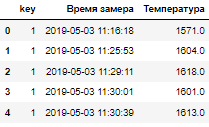